## Part II: VGG-16 and Resnet-18 Implementation for image classification

The dataset consists of 30,000 images (10,000 images per class) of dogs, cars, and food.
Each image is 64x64 pixels

In [22]:
import torch
import torchvision
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import time
from torch import torch, nn, optim
from collections import Counter
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torchinfo import summary

In [2]:
datapath = "./dataset/images"

In [3]:
transform = transforms.Compose([
    # transforms.Resize((28, 28)),            
    # transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.ToTensor(),                 
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
torch.manual_seed(42)
random.seed(42)
torch.mps.manual_seed(42)

### Step 1: Data preparation

Load CNN dataset.

In [5]:
data = ImageFolder(datapath, transform=transform)

Analyze the dataset.

In [6]:
classes = data.classes
classes

['dogs', 'food', 'vehicles']

In [7]:
print(f"Total samples: {len(data)}")
print(f"Number of classes: {len(data.classes)}")

Total samples: 30000
Number of classes: 3


In [8]:
# Count the occurrences of each class in the dataset
class_counts = Counter([data.targets[i] for i in range(len(data))])

# Map the class indices to their names and print
class_lengths = {data.classes[i]: class_counts[i] for i in range(len(data.classes))}
print(class_lengths)

{'dogs': 10000, 'food': 10000, 'vehicles': 10000}


Visualizations of dataset

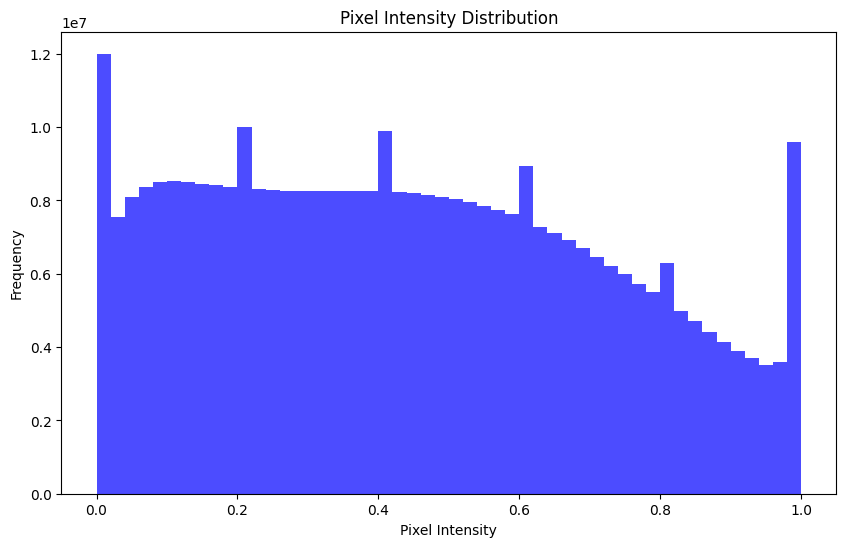

In [10]:
# Convert the entire dataset to a numpy array for pixel analysis
all_images = np.concatenate([data[i][0].numpy().flatten() for i in range(len(data))])
# all_images = all_images/ 2 + 0.5 
plt.figure(figsize=(10, 6))
plt.hist(all_images, bins=50, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()


The data here already seems to be concentrated between 0 to 1 in pixel intensity so we don't have to normalize the images explicitly.

Split the dataset into training, testing, and validation sets.

In [11]:
total_samples = len(data)
train_size = int(0.7 * total_samples)  # 70% for training
val_size = int(0.15 * total_samples)    # 15% for validation
test_size = total_samples - train_size - val_size  # Remainder for testing

In [12]:
# Splitting the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

In [13]:
batch_size = 64

In [14]:
# DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [15]:
images, labels = next(iter(train_loader))
print(f"Batch of images has shape: {images.shape}")
print(f"Batch of labels has shape: {labels.shape}")

Batch of images has shape: torch.Size([64, 3, 64, 64])
Batch of labels has shape: torch.Size([64])


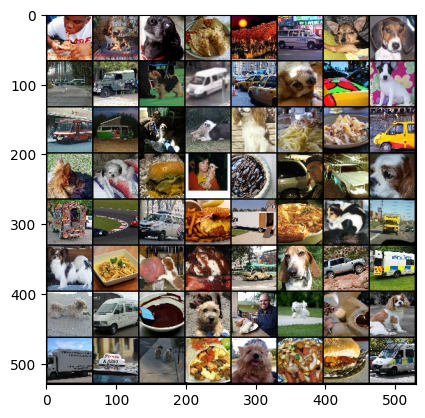

food  dogs  dogs  food  food  vehicles dogs  dogs  vehicles vehicles dogs  vehicles vehicles dogs  vehicles dogs  vehicles vehicles dogs  dogs  dogs  food  food  vehicles dogs  dogs  food  dogs  food  vehicles vehicles dogs  vehicles vehicles vehicles food  vehicles food  dogs  vehicles dogs  food  dogs  food  vehicles dogs  vehicles vehicles dogs  vehicles food  dogs  food  dogs  food  dogs  vehicles vehicles dogs  food  dogs  food  food  vehicles


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Step 2: Implementing VGG-16

In [19]:
class VGG16Imp(nn.Module):
    def __init__(self, num_classes=3, init_method='xavier'):
        super(VGG16Imp, self).__init__()
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x32
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x16

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 8x8
            
            # Block 4 
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 4x4

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 2x2
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(4096, 3)  # Adjusted to 3 classes
        )
         # Apply weight initialization
        self._initialize_weights(init_method)
        
    def _initialize_weights(self, init_method):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if init_method == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif init_method == 'kaiming':
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)  # Set biases to 0
               
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x


In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [20]:
epochs = 10

#### Experimenting with weight initialization strategies.

##### Xavier initialization

In [23]:
model_sum = VGG16Imp().to(device)

In [24]:
summary(model_sum, (64,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16Imp                                 [64, 3]                   --
├─Sequential: 1-1                        [64, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [64, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [64, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [64, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [64, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [64, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [64, 128, 32, 32]         73,856
│    └─ReLU: 2-7                         [64, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [64, 128, 32, 32]         147,584
│    └─ReLU: 2-9                         [64, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [64, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [64, 256, 16, 16]         29

In [25]:
model_xavier = VGG16Imp(init_method='xavier').to(device)

In [26]:
loss_fn_xavier = nn.CrossEntropyLoss()
optimizer_xavier = torch.optim.Adam(model_xavier.parameters(), lr=3e-4)
scheduler_xavier = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_xavier, mode='min', patience=3, factor=0.1)


In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    train_loss , correct, total =0 , 0, 0
    # zero the parameter gradients
    
    
    for batch, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    

        if batch % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{batch + 1}] loss: {train_loss / (batch+1):.3f}')
        
    # Calculate average loss and accuracy
    average_loss = train_loss / num_batches
    accuracy_train = 100 * correct / total
    
    return average_loss, accuracy_train

def validation_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            # Accumulate loss
            val_loss += loss.item()

            # Calculate number of correct predictions
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate average loss and accuracy
    average_loss = val_loss / len(dataloader)
    accuracy_val = 100 * correct / total
    
    return average_loss,accuracy_val

In [28]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    predictions=[]
    actual=[]
    test_loss = 0
    num_batches= len(dataloader)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            # Accumulate loss
            test_loss += loss.item()

            # Calculate number of correct predictions
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            actual.extend(labels.cpu().numpy())
            
        
    accuracy = accuracy_score(actual, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(actual, predictions, average='weighted')
    print(f"Test Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    # Average test loss over all batches
    test_loss /= num_batches
    print("Test loss is", test_loss)
    return test_loss, accuracy,actual, predictions

In [29]:
start_time = time.time()
train_acc_xavier = []
validation_acc_xavier = []
train_loss_xavier = []
validation_loss_xavier = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_xavier, loss_fn_xavier, optimizer_xavier)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_xavier, loss_fn_xavier)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_xavier.step(v_loss)
    
    train_acc_xavier.append(acc)
    validation_acc_xavier.append(v_acc)
    train_loss_xavier.append(loss)
    validation_loss_xavier.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_xavier.state_dict():
#     print(param_tensor, "\t", model_xavier.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_xavier)/len(train_acc_xavier))

print("Validation accuracy is", sum(validation_acc_xavier)/len(validation_acc_xavier))

Epoch [1/10], Loss: 0.742, Accuracy: 64.26%
Epoch [1/10], Validation Loss: 0.434, Validation Accuracy: 82.76%
Epoch [2/10], Loss: 0.440, Accuracy: 83.35%
Epoch [2/10], Validation Loss: 0.512, Validation Accuracy: 81.69%
Epoch [3/10], Loss: 0.357, Accuracy: 86.68%
Epoch [3/10], Validation Loss: 0.366, Validation Accuracy: 86.20%
Epoch [4/10], Loss: 0.300, Accuracy: 89.09%
Epoch [4/10], Validation Loss: 0.294, Validation Accuracy: 89.27%
Epoch [5/10], Loss: 0.260, Accuracy: 90.58%
Epoch [5/10], Validation Loss: 0.244, Validation Accuracy: 91.11%
Epoch [6/10], Loss: 0.225, Accuracy: 91.81%
Epoch [6/10], Validation Loss: 0.363, Validation Accuracy: 87.89%
Epoch [7/10], Loss: 0.208, Accuracy: 92.50%
Epoch [7/10], Validation Loss: 0.236, Validation Accuracy: 90.64%
Epoch [8/10], Loss: 0.193, Accuracy: 93.04%
Epoch [8/10], Validation Loss: 0.202, Validation Accuracy: 92.62%
Epoch [9/10], Loss: 0.166, Accuracy: 94.03%
Epoch [9/10], Validation Loss: 0.205, Validation Accuracy: 92.58%
Epoch [10/

In [30]:
test_loss_xavier , test_accuracy_xavier = 0,0
actual_values_xavier = []
predicted_val_xavier = []
test_loss_xavier, test_accuracy_xavier, actual_values_xavier, predicted_val_xavier = test_loop(test_loader, model_xavier, loss_fn_xavier)

Test Accuracy: 0.9311111111111111, Precision: 0.9329522656838745, Recall: 0.9311111111111111, F1 Score: 0.9313009842480627
Test loss is 0.1861893687607117


##### Kaiming initialization

In [31]:
model_kaiming = VGG16Imp(init_method='kaiming').to(device)

In [32]:
loss_fn_kaiming = nn.CrossEntropyLoss()
optimizer_kaiming = torch.optim.Adam(model_kaiming.parameters(), lr=3e-4)
scheduler_kaiming = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_kaiming, mode='min', patience=3, factor=0.1)

In [33]:
start_time = time.time()
train_acc_kaiming = []
validation_acc_kaiming = []
train_loss_kaiming = []
validation_loss_kaiming = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_kaiming, loss_fn_kaiming, optimizer_kaiming)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_kaiming, loss_fn_kaiming)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_kaiming.step(v_loss)
    
    train_acc_kaiming.append(acc)
    validation_acc_kaiming.append(v_acc)
    train_loss_kaiming.append(loss)
    validation_loss_kaiming.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_kaiming.state_dict():
#     print(param_tensor, "\t", model_kaiming.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_kaiming)/len(train_acc_kaiming))

print("Validation accuracy is", sum(validation_acc_kaiming)/len(validation_acc_kaiming))

Epoch [1/10], Loss: 0.600, Accuracy: 75.54%
Epoch [1/10], Validation Loss: 0.426, Validation Accuracy: 83.69%
Epoch [2/10], Loss: 0.367, Accuracy: 86.68%
Epoch [2/10], Validation Loss: 0.341, Validation Accuracy: 87.76%
Epoch [3/10], Loss: 0.290, Accuracy: 89.66%
Epoch [3/10], Validation Loss: 0.267, Validation Accuracy: 90.87%
Epoch [4/10], Loss: 0.249, Accuracy: 90.73%
Epoch [4/10], Validation Loss: 0.611, Validation Accuracy: 76.78%
Epoch [5/10], Loss: 0.229, Accuracy: 91.59%
Epoch [5/10], Validation Loss: 0.246, Validation Accuracy: 90.96%
Epoch [6/10], Loss: 0.180, Accuracy: 93.38%
Epoch [6/10], Validation Loss: 0.242, Validation Accuracy: 90.96%
Epoch [7/10], Loss: 0.153, Accuracy: 94.60%
Epoch [7/10], Validation Loss: 0.276, Validation Accuracy: 89.09%
Epoch [8/10], Loss: 0.136, Accuracy: 95.17%
Epoch [8/10], Validation Loss: 0.177, Validation Accuracy: 93.56%
Epoch [9/10], Loss: 0.107, Accuracy: 96.24%
Epoch [9/10], Validation Loss: 0.276, Validation Accuracy: 91.69%
Epoch [10/

In [34]:
test_loss_kaiming , test_accuracy_kaiming = 0,0
actual_values_kaiming = []
predicted_val_kaiming = []
test_loss_kaiming, test_accuracy_kaiming, actual_values_kaiming, predicted_val_kaiming = test_loop(test_loader, model_kaiming, loss_fn_kaiming)

Test Accuracy: 0.9228888888888889, Precision: 0.9235799379609971, Recall: 0.9228888888888889, F1 Score: 0.9229359533101736
Test loss is 0.23885158444164503


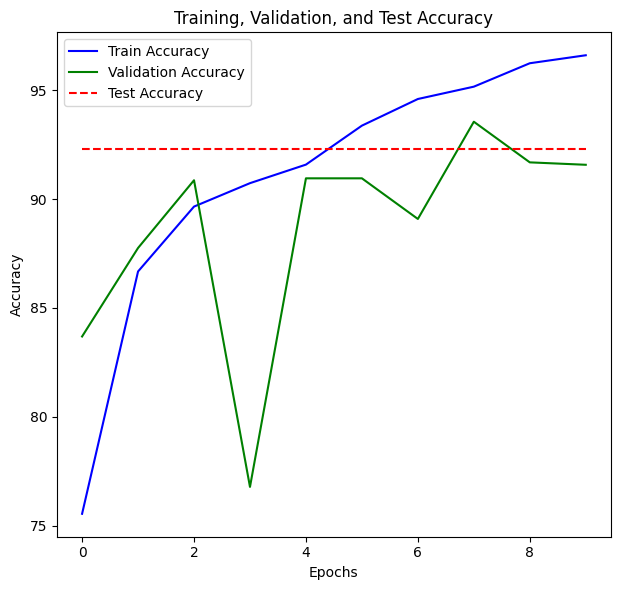

In [35]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_kaiming = [test_accuracy_kaiming * 100] * epochs

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_kaiming, label="Train Accuracy", color='b')
plt.plot(range(epochs), validation_acc_kaiming, label="Validation Accuracy", color='g')
plt.plot(range(epochs), test_acc_kaiming, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

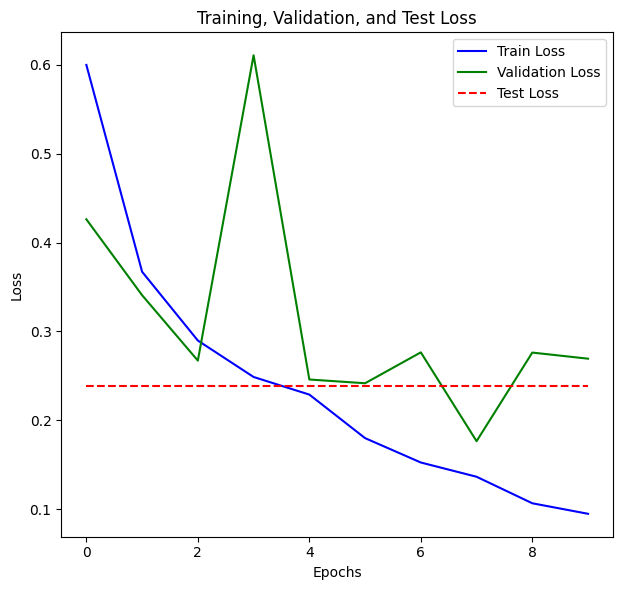

In [36]:
test_loss_kaiming = [test_loss_kaiming] * epochs

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_kaiming, label="Train Loss", color='b')
plt.plot(range(epochs), validation_loss_kaiming, label="Validation Loss", color='g')
plt.plot(range(epochs), test_loss_kaiming, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

#### Testing with different optimizers

In [37]:
batch_size = 64

In [38]:
epochs = 20

##### ADAM

In [39]:
model_Adam = VGG16Imp(init_method='kaiming').to(device)

In [40]:
loss_fn_Adam = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=3e-4)
scheduler_Adam = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_Adam, mode='min', patience=3, factor=0.1)

In [41]:
start_time = time.time()
train_acc_Adam = []
validation_acc_Adam = []
train_loss_Adam = []
validation_loss_Adam = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_Adam, loss_fn_Adam, optimizer_Adam)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_Adam, loss_fn_Adam)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_Adam.step(v_loss)
    
    train_acc_Adam.append(acc)
    validation_acc_Adam.append(v_acc)
    train_loss_Adam.append(loss)
    validation_loss_Adam.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_Adam.state_dict():
#     print(param_tensor, "\t", model_Adam.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_Adam)/len(train_acc_Adam))

print("Validation accuracy is", sum(validation_acc_Adam)/len(validation_acc_Adam))

Epoch [1/20], Loss: 0.645, Accuracy: 72.47%
Epoch [1/20], Validation Loss: 0.609, Validation Accuracy: 72.47%
Epoch [2/20], Loss: 0.382, Accuracy: 85.90%
Epoch [2/20], Validation Loss: 0.366, Validation Accuracy: 85.84%
Epoch [3/20], Loss: 0.308, Accuracy: 88.61%
Epoch [3/20], Validation Loss: 0.289, Validation Accuracy: 89.09%
Epoch [4/20], Loss: 0.259, Accuracy: 90.54%
Epoch [4/20], Validation Loss: 0.274, Validation Accuracy: 90.33%
Epoch [5/20], Loss: 0.216, Accuracy: 92.18%
Epoch [5/20], Validation Loss: 0.251, Validation Accuracy: 90.69%
Epoch [6/20], Loss: 0.196, Accuracy: 92.97%
Epoch [6/20], Validation Loss: 0.217, Validation Accuracy: 91.96%
Epoch [7/20], Loss: 0.149, Accuracy: 94.60%
Epoch [7/20], Validation Loss: 0.247, Validation Accuracy: 91.73%
Epoch [8/20], Loss: 0.134, Accuracy: 95.43%
Epoch [8/20], Validation Loss: 0.231, Validation Accuracy: 92.24%
Epoch [9/20], Loss: 0.115, Accuracy: 95.91%
Epoch [9/20], Validation Loss: 0.215, Validation Accuracy: 92.76%
Epoch [10/

In [42]:
test_loss_Adam , test_accuracy_Adam = 0,0
actual_values_Adam = []
predicted_val_Adam = []
test_loss_Adam, test_accuracy_Adam, actual_values_Adam, predicted_val_Adam = test_loop(test_loader, model_Adam, loss_fn_Adam)

Test Accuracy: 0.9442222222222222, Precision: 0.9443679371824388, Recall: 0.9442222222222222, F1 Score: 0.9442341184513328
Test loss is 0.3302974839763766


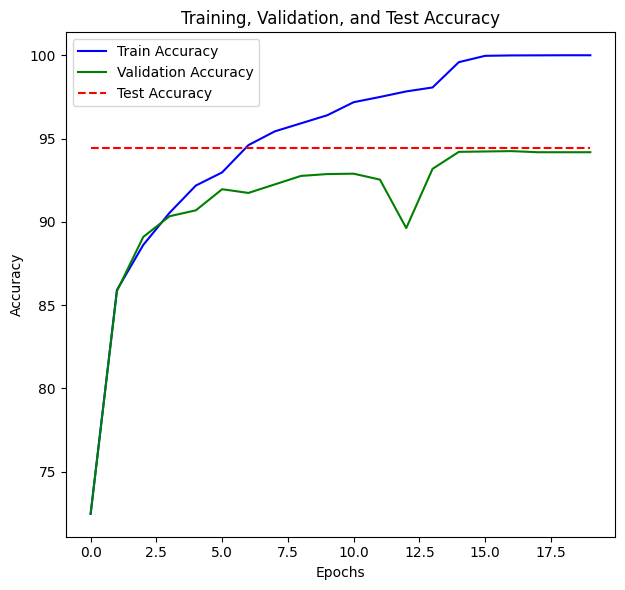

In [43]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_Adam = [test_accuracy_Adam * 100] * epochs

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_Adam, label="Train Accuracy", color='b')
plt.plot(range(epochs), validation_acc_Adam, label="Validation Accuracy", color='g')
plt.plot(range(epochs), test_acc_Adam, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

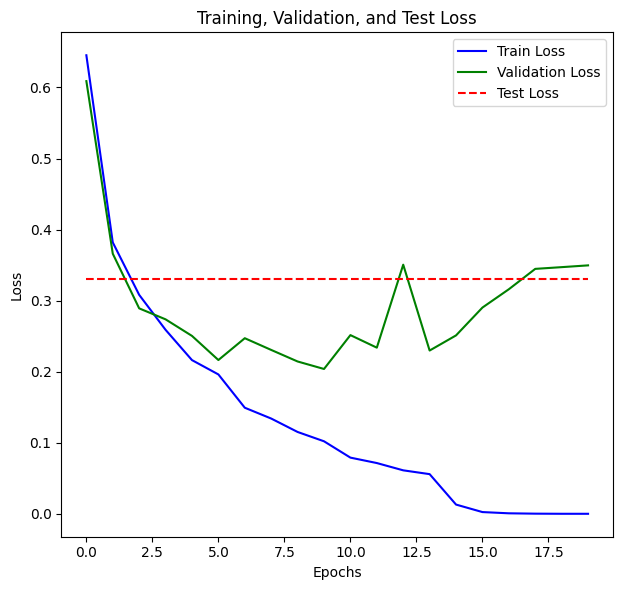

In [44]:
test_loss_Adam = [test_loss_Adam] * epochs

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_Adam, label="Train Loss", color='b')
plt.plot(range(epochs), validation_loss_Adam, label="Validation Loss", color='g')
plt.plot(range(epochs), test_loss_Adam, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

##### AdamW

In [45]:
model_W = VGG16Imp(init_method='kaiming').to(device)

In [46]:
loss_fn_W = nn.CrossEntropyLoss()
optimizer_W = torch.optim.AdamW(model_W.parameters(), lr=3e-4)
scheduler_W = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_W, mode='min', patience=3, factor=0.1)

In [47]:
start_time = time.time()
train_acc_W = []
validation_acc_W = []
train_loss_W = []
validation_loss_W = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_W, loss_fn_W, optimizer_W)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_W, loss_fn_W)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_W.step(v_loss)
    
    train_acc_W.append(acc)
    validation_acc_W.append(v_acc)
    train_loss_W.append(loss)
    validation_loss_W.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_W.state_dict():
#     print(param_tensor, "\t", model_W.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_W)/len(train_acc_W))

print("Validation accuracy is", sum(validation_acc_W)/len(validation_acc_W))

Epoch [1/20], Loss: 0.641, Accuracy: 74.61%
Epoch [1/20], Validation Loss: 0.428, Validation Accuracy: 83.78%
Epoch [2/20], Loss: 0.367, Accuracy: 86.47%
Epoch [2/20], Validation Loss: 0.325, Validation Accuracy: 88.20%
Epoch [3/20], Loss: 0.293, Accuracy: 89.53%
Epoch [3/20], Validation Loss: 0.281, Validation Accuracy: 90.13%
Epoch [4/20], Loss: 0.247, Accuracy: 91.12%
Epoch [4/20], Validation Loss: 0.236, Validation Accuracy: 91.33%
Epoch [5/20], Loss: 0.210, Accuracy: 92.42%
Epoch [5/20], Validation Loss: 0.252, Validation Accuracy: 90.38%
Epoch [6/20], Loss: 0.184, Accuracy: 93.51%
Epoch [6/20], Validation Loss: 0.223, Validation Accuracy: 92.20%
Epoch [7/20], Loss: 0.154, Accuracy: 94.69%
Epoch [7/20], Validation Loss: 0.210, Validation Accuracy: 92.82%
Epoch [8/20], Loss: 0.132, Accuracy: 95.20%
Epoch [8/20], Validation Loss: 0.192, Validation Accuracy: 92.76%
Epoch [9/20], Loss: 0.110, Accuracy: 96.02%
Epoch [9/20], Validation Loss: 0.212, Validation Accuracy: 92.80%
Epoch [10/

In [48]:
test_loss_W , test_accuracy_W = 0,0
actual_values_W = []
predicted_val_W = []
test_loss_W, test_accuracy_W, actual_values_W, predicted_val_W = test_loop(test_loader, model_W, loss_fn_W)

Test Accuracy: 0.9435555555555556, Precision: 0.9435474088924606, Recall: 0.9435555555555556, F1 Score: 0.9435444093373018
Test loss is 0.35511641417893536


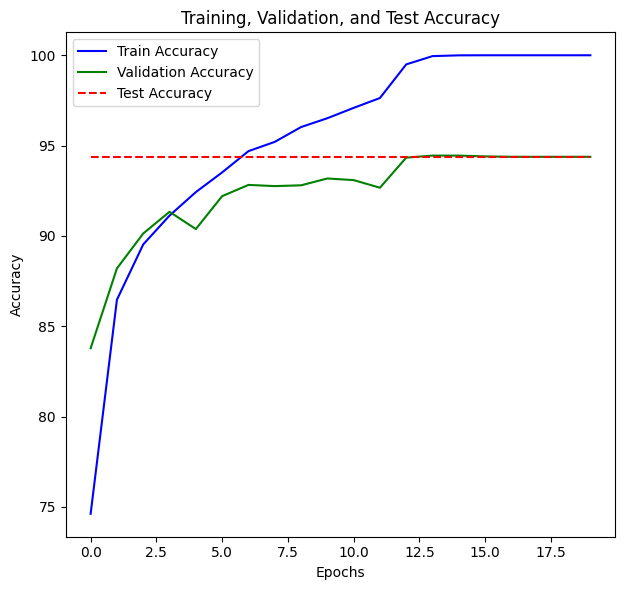

In [49]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_AdamW = [test_accuracy_W * 100] * epochs

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_W, label="Train Accuracy", color='b')
plt.plot(range(epochs), validation_acc_W, label="Validation Accuracy", color='g')
plt.plot(range(epochs), test_acc_AdamW, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

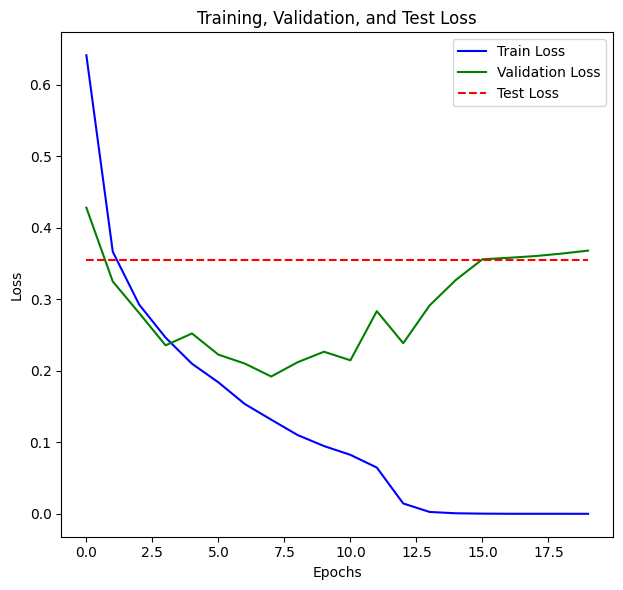

In [50]:
test_loss_AdamW = [test_loss_W] * epochs

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_W, label="Train Loss", color='b')
plt.plot(range(epochs), validation_loss_W, label="Validation Loss", color='g')
plt.plot(range(epochs), test_loss_AdamW, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

##### RMSProp

In [51]:
model_RMS = VGG16Imp(init_method='kaiming').to(device)

In [52]:
loss_fn_RMS = nn.CrossEntropyLoss()
optimizer_RMS = torch.optim.RMSprop(model_RMS.parameters(), lr=3e-4)
scheduler_RMS = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_RMS, mode='min', patience=3, factor=0.1)

In [53]:
start_time = time.time()
train_acc_RMS = []
validation_acc_RMS = []
train_loss_RMS = []
validation_loss_RMS = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_RMS, loss_fn_RMS, optimizer_RMS)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_RMS, loss_fn_RMS)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_RMS.step(v_loss)
    
    train_acc_RMS.append(acc)
    validation_acc_RMS.append(v_acc)
    train_loss_RMS.append(loss)
    validation_loss_RMS.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_RMS.state_dict():
#     print(param_tensor, "\t", model_RMS.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_RMS)/len(train_acc_RMS))

print("Validation accuracy is", sum(validation_acc_RMS)/len(validation_acc_RMS))

Epoch [1/20], Loss: 50.975, Accuracy: 39.73%
Epoch [1/20], Validation Loss: 0.986, Validation Accuracy: 37.51%
Epoch [2/20], Loss: 0.645, Accuracy: 73.41%
Epoch [2/20], Validation Loss: 0.526, Validation Accuracy: 79.16%
Epoch [3/20], Loss: 0.443, Accuracy: 83.18%
Epoch [3/20], Validation Loss: 0.490, Validation Accuracy: 80.27%
Epoch [4/20], Loss: 0.413, Accuracy: 84.48%
Epoch [4/20], Validation Loss: 0.468, Validation Accuracy: 82.00%
Epoch [5/20], Loss: 0.345, Accuracy: 86.95%
Epoch [5/20], Validation Loss: 0.297, Validation Accuracy: 89.62%
Epoch [6/20], Loss: 0.307, Accuracy: 88.50%
Epoch [6/20], Validation Loss: 0.312, Validation Accuracy: 90.31%
Epoch [7/20], Loss: 0.261, Accuracy: 90.81%
Epoch [7/20], Validation Loss: 0.755, Validation Accuracy: 67.96%
Epoch [8/20], Loss: 0.217, Accuracy: 91.96%
Epoch [8/20], Validation Loss: 0.241, Validation Accuracy: 91.22%
Epoch [9/20], Loss: 0.181, Accuracy: 93.45%
Epoch [9/20], Validation Loss: 0.233, Validation Accuracy: 91.53%
Epoch [10

In [54]:
test_loss_RMS , test_accuracy_RMS = 0,0
actual_values_RMS = []
predicted_val_RMS = []
test_loss_RMS, test_accuracy_RMS, actual_values_RMS, predicted_val_RMS = test_loop(test_loader, model_RMS, loss_fn_RMS)

Test Accuracy: 0.9282222222222222, Precision: 0.9282408846746398, Recall: 0.9282222222222222, F1 Score: 0.9281911228493166
Test loss is 0.8630137408704862


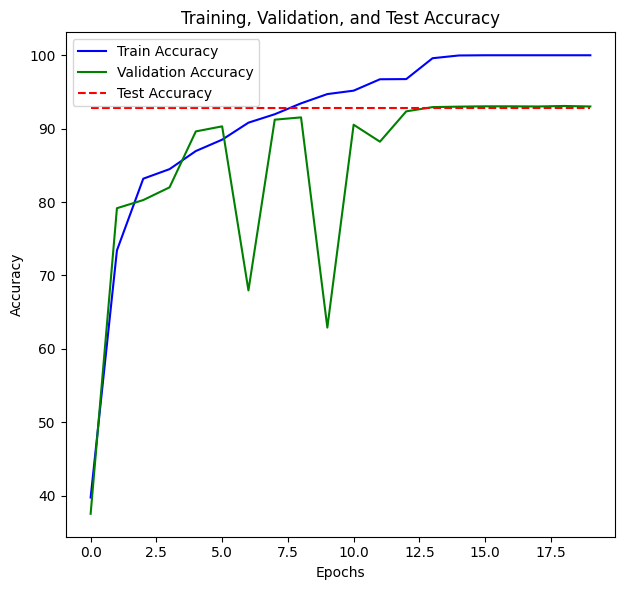

In [55]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_RMS = [test_accuracy_RMS * 100] * epochs

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_RMS, label="Train Accuracy", color='b')
plt.plot(range(epochs), validation_acc_RMS, label="Validation Accuracy", color='g')
plt.plot(range(epochs), test_acc_RMS, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

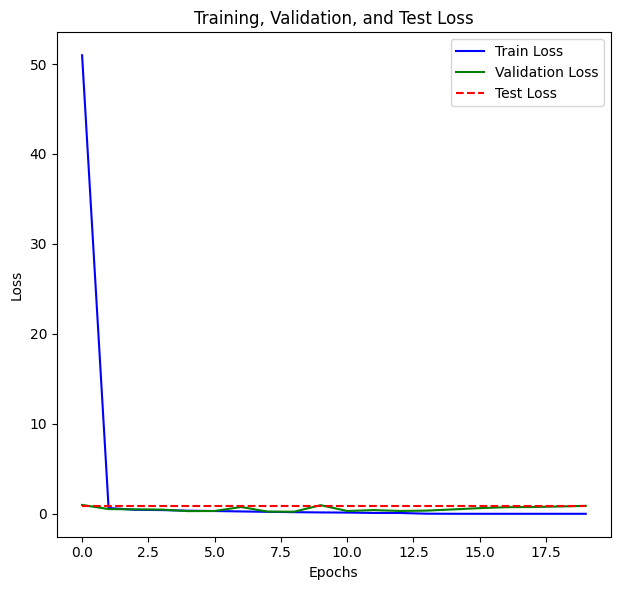

In [56]:
test_loss_RMS = [test_loss_RMS] * epochs

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_RMS, label="Train Loss", color='b')
plt.plot(range(epochs), validation_loss_RMS, label="Validation Loss", color='g')
plt.plot(range(epochs), test_loss_RMS, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Discussion on optimizer

From the above results, we can see that **AdamW** performs the best out of **Adam** and **AdamW**. <br> 

**Adam** reaches **95.59%** training accuracy with fast convergence. However, the high training accuracy could indicate a risk of overfitting. Test loss is **0.3454**.  <br>

**AdamW** reaches **95.21%** training accuracy, which suggests better generalization but slightly slower convergence compared to Adam. Test loss is **0.3527**.  <br>

**RMSProp** reches 90.67% training accuracy but has instability in validation and larger accuracy fluctuations. Test loss is 0.702127379971117 <br>
Since AdamW maintains **higher validation accuracy** and avoids extreme overfitting while having similar test performance, we will go with **AdamW** as it shows **better generalization**.

#### Testing with different batch sizes

##### Batchsize 32

In [53]:
# DataLoaders for training, validation, and test sets
train_loader_size32 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_size32 = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader_size32 = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
model_size32 = VGG16Imp(init_method='kaiming').to(device)

In [55]:
loss_fn_size32 = nn.CrossEntropyLoss()
optimizer_size32 = torch.optim.AdamW(model_size32.parameters(), lr=3e-4)
scheduler_size32 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_size32, mode='min', patience=3, factor=0.1)

In [56]:
start_time = time.time()
train_acc_size32 = []
validation_acc_size32 = []
train_loss_size32 = []
validation_loss_size32 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader_size32, model_size32, loss_fn_size32, optimizer_size32)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader_size32, model_size32, loss_fn_size32)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_size32.step(v_loss)
    
    train_acc_size32.append(acc)
    validation_acc_size32.append(v_acc)
    train_loss_size32.append(loss)
    validation_loss_size32.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_size32.state_dict():
#     print(param_tensor, "\t", model_size32.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_size32)/len(train_acc_size32))

print("Validation accuracy is", sum(validation_acc_size32)/len(validation_acc_size32))

Epoch [1/20], Loss: 0.576, Accuracy: 76.88%
Epoch [1/20], Validation Loss: 0.412, Validation Accuracy: 85.76%
Epoch [2/20], Loss: 0.362, Accuracy: 86.54%
Epoch [2/20], Validation Loss: 0.327, Validation Accuracy: 87.91%
Epoch [3/20], Loss: 0.292, Accuracy: 89.50%
Epoch [3/20], Validation Loss: 0.282, Validation Accuracy: 89.62%
Epoch [4/20], Loss: 0.255, Accuracy: 90.75%
Epoch [4/20], Validation Loss: 0.263, Validation Accuracy: 90.47%
Epoch [5/20], Loss: 0.216, Accuracy: 92.19%
Epoch [5/20], Validation Loss: 0.234, Validation Accuracy: 91.00%
Epoch [6/20], Loss: 0.181, Accuracy: 93.51%
Epoch [6/20], Validation Loss: 0.231, Validation Accuracy: 91.78%
Epoch [7/20], Loss: 0.153, Accuracy: 94.48%
Epoch [7/20], Validation Loss: 0.228, Validation Accuracy: 91.62%
Epoch [8/20], Loss: 0.139, Accuracy: 95.17%
Epoch [8/20], Validation Loss: 0.261, Validation Accuracy: 90.89%
Epoch [9/20], Loss: 0.117, Accuracy: 95.94%
Epoch [9/20], Validation Loss: 0.202, Validation Accuracy: 93.29%
Epoch [10/

In [57]:
test_loss_size32 , test_accuracy_size32 = 0,0
actual_values_size32 = []
predicted_val_size32 = []
test_loss_size32, test_accuracy_size32, actual_values_size32, predicted_val_size32 = test_loop(test_loader_size32, model_size32, loss_fn_size32)

Test Accuracy: 0.9428888888888889, Precision: 0.9428600213436271, Recall: 0.9428888888888889, F1 Score: 0.9428555513789106
Test loss is 0.36875096523145007


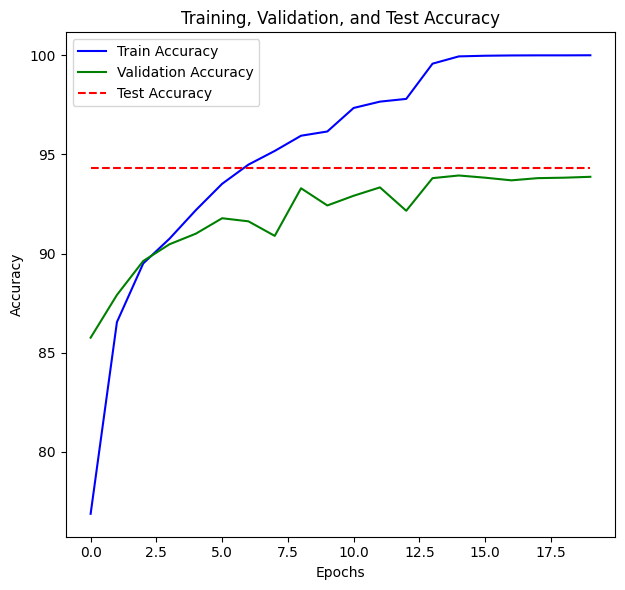

In [58]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_size32 = [test_accuracy_size32 * 100] * epochs

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_size32, label="Train Accuracy", color='b')
plt.plot(range(epochs), validation_acc_size32, label="Validation Accuracy", color='g')
plt.plot(range(epochs), test_acc_size32, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

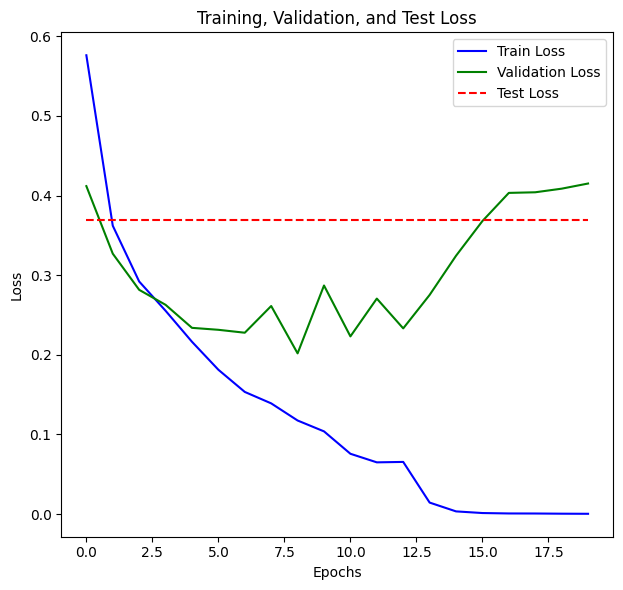

In [59]:
test_loss_size32 = [test_loss_size32] * epochs

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_size32, label="Train Loss", color='b')
plt.plot(range(epochs), validation_loss_size32, label="Validation Loss", color='g')
plt.plot(range(epochs), test_loss_size32, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

##### Batchsize 128

In [60]:
# DataLoaders for training, validation, and test sets
train_loader_size128 = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_size128 = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_size128 = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [61]:
model_size128 = VGG16Imp(init_method='kaiming').to(device)

In [62]:
loss_fn_size128 = nn.CrossEntropyLoss()
optimizer_size128 = torch.optim.AdamW(model_size128.parameters(), lr=3e-4)
scheduler_size128 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_size128, mode='min', patience=3, factor=0.1)

In [63]:
start_time = time.time()
train_acc_size128 = []
validation_acc_size128 = []
train_loss_size128 = []
validation_loss_size128 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader_size128, model_size128, loss_fn_size128, optimizer_size128)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader_size128, model_size128, loss_fn_size128)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_size128.step(v_loss)

    train_acc_size128.append(acc)
    validation_acc_size128.append(v_acc)
    train_loss_size128.append(loss)
    validation_loss_size128.append(v_loss)


# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_size128.state_dict():
#     print(param_tensor, "\t", model_size128.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_size128)/len(train_acc_size128))

print("Validation accuracy is", sum(validation_acc_size128)/len(validation_acc_size128))

Epoch [1/20], Loss: 0.756, Accuracy: 68.10%
Epoch [1/20], Validation Loss: 0.400, Validation Accuracy: 84.13%
Epoch [2/20], Loss: 0.391, Accuracy: 85.22%
Epoch [2/20], Validation Loss: 0.443, Validation Accuracy: 83.36%
Epoch [3/20], Loss: 0.308, Accuracy: 88.38%
Epoch [3/20], Validation Loss: 0.417, Validation Accuracy: 81.38%
Epoch [4/20], Loss: 0.258, Accuracy: 90.52%
Epoch [4/20], Validation Loss: 0.413, Validation Accuracy: 84.40%
Epoch [5/20], Loss: 0.222, Accuracy: 91.91%
Epoch [5/20], Validation Loss: 0.383, Validation Accuracy: 87.18%
Epoch [6/20], Loss: 0.225, Accuracy: 92.12%
Epoch [6/20], Validation Loss: 0.201, Validation Accuracy: 92.78%
Epoch [7/20], Loss: 0.173, Accuracy: 93.72%
Epoch [7/20], Validation Loss: 0.217, Validation Accuracy: 92.02%
Epoch [8/20], Loss: 0.140, Accuracy: 95.04%
Epoch [8/20], Validation Loss: 0.239, Validation Accuracy: 91.13%
Epoch [9/20], Loss: 0.112, Accuracy: 95.99%
Epoch [9/20], Validation Loss: 0.208, Validation Accuracy: 92.60%
Epoch [10/

In [64]:
test_loss_size128 , test_accuracy_size128 = 0,0
actual_values_size128 = []
predicted_val_size128 = []
test_loss_size128, test_accuracy_size128, actual_values_size128, predicted_val_size128 = test_loop(test_loader_size128, model_size128, loss_fn_size128)

Test Accuracy: 0.9382222222222222, Precision: 0.9384406045619806, Recall: 0.9382222222222222, F1 Score: 0.9382697582754408
Test loss is 0.33635303960020085


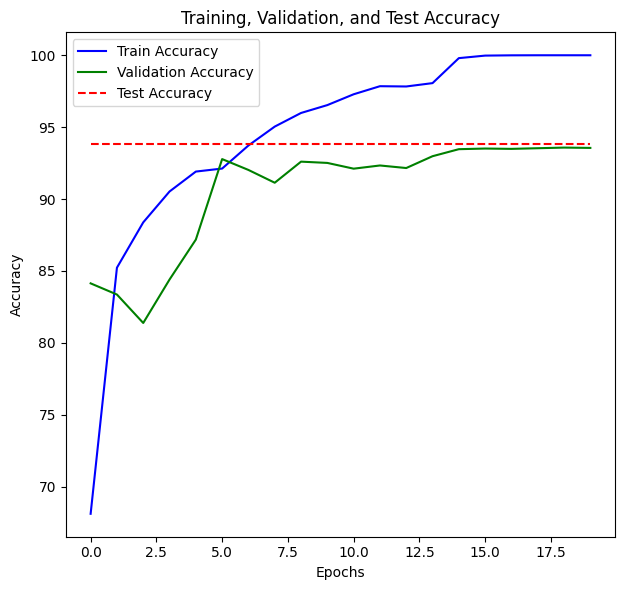

In [65]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_size128 = [test_accuracy_size128 * 100] * epochs

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_size128, label="Train Accuracy", color='b')
plt.plot(range(epochs), validation_acc_size128, label="Validation Accuracy", color='g')
plt.plot(range(epochs), test_acc_size128, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

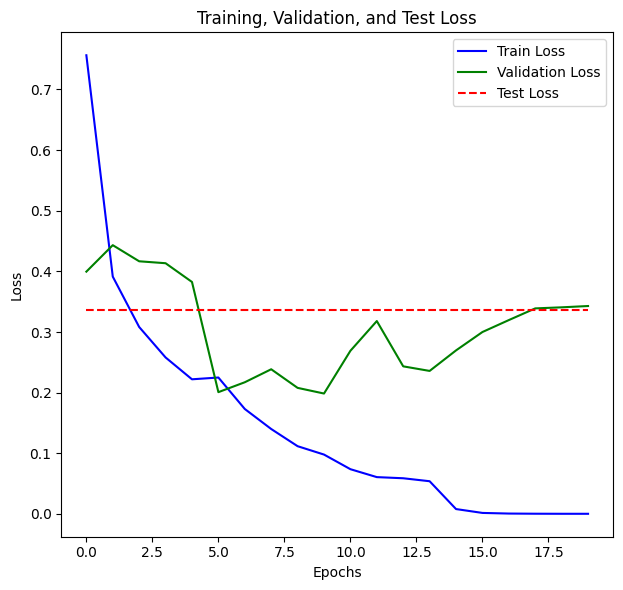

In [66]:
test_loss_size128 = [test_loss_size128] * epochs

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_size128, label="Train Loss", color='b')
plt.plot(range(epochs), validation_loss_size128, label="Validation Loss", color='g')
plt.plot(range(epochs), test_loss_size128, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Discussion on batch size

From above we can see that Batch size 64 performs the best out of 32, 64 and 128 <br>
With **batch size = 32**, we achieve good training and test accuracy of ~94.3% with 1300 seconds of training time. Test loss is 0.3688.<br>
With **batch size=64** , we achieve > 94.4% training and test accuracy. It's faster than batch size 32 with 1100 seconds of training time. Test loss is 0.3527. <br>
With **batch size=128**, we also get > 93.8% training and test accuracy, and it is the fastest with 989 seconds of training time. Test loss is 0.3364. <br>
Since batch size 64 has the highest test accuracy and a low test loss, while still maintaining a good balance between accuracy and training time, it would be the preferred choice. However, batch size 128 could also be chosen if training time is a higher priority.

### Base model - Confusion matrix for batch size 64

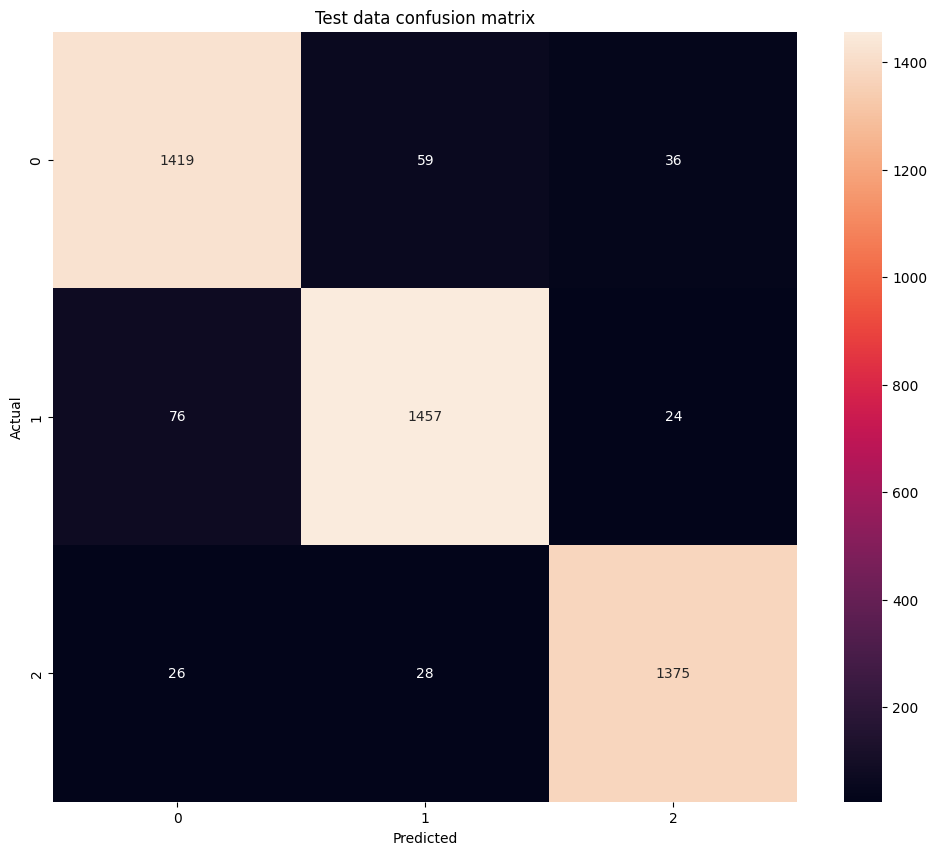

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix_test = confusion_matrix(actual_values_W, predicted_val_W)
plt.figure(figsize=(12, 10))
s = sns.heatmap(confusion_matrix_test, annot=True, fmt='d', xticklabels=np.arange(3), yticklabels=np.arange(3))
s.set(xlabel='Predicted', ylabel='Actual')
s.set_title('Test data confusion matrix')
plt.show()

### Applying regularization and overfitting prevention techniques.

#### i) Early stopping

In [68]:
model_es = VGG16Imp(init_method='kaiming').to(device)

In [69]:
loss_fn_es = nn.CrossEntropyLoss()
optimizer_es = torch.optim.AdamW(model_es.parameters(), lr=3e-4)
scheduler_es = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_es, mode='min', patience=3, factor=0.1)

In [70]:
start_time = time.time()
train_acc_es = []
validation_acc_es = []
train_loss_es = []
validation_loss_es = []

best_loss = float("inf")
patience_counter = 0 
patience = 4

for t in range(epochs):
    loss, acc = train_loop(train_loader, model_es, loss_fn_es, optimizer_es)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_es, loss_fn_es)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")
       # Early stopping 
    if v_loss < best_loss:
        best_loss = v_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience:
        print(f"Early stopping! Training stopped after {t} epochs")
        break
    scheduler_es.step(v_loss)

    train_acc_es.append(acc)
    validation_acc_es.append(v_acc)
    train_loss_es.append(loss)
    validation_loss_es.append(v_loss)


# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_es.state_dict():
#     print(param_tensor, "\t", model_es.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_es)/len(train_acc_es))

print("Validation accuracy is", sum(validation_acc_es)/len(validation_acc_es))

Epoch [1/20], Loss: 0.656, Accuracy: 71.72%
Epoch [1/20], Validation Loss: 0.485, Validation Accuracy: 80.22%
Epoch [2/20], Loss: 0.385, Accuracy: 85.51%
Epoch [2/20], Validation Loss: 0.329, Validation Accuracy: 86.80%
Epoch [3/20], Loss: 0.306, Accuracy: 88.43%
Epoch [3/20], Validation Loss: 0.284, Validation Accuracy: 89.40%
Epoch [4/20], Loss: 0.256, Accuracy: 90.82%
Epoch [4/20], Validation Loss: 0.275, Validation Accuracy: 89.11%
Epoch [5/20], Loss: 0.222, Accuracy: 92.00%
Epoch [5/20], Validation Loss: 0.248, Validation Accuracy: 90.64%
Epoch [6/20], Loss: 0.200, Accuracy: 92.68%
Epoch [6/20], Validation Loss: 0.208, Validation Accuracy: 92.33%
Epoch [7/20], Loss: 0.167, Accuracy: 93.89%
Epoch [7/20], Validation Loss: 0.288, Validation Accuracy: 90.49%
No improvement for 1 epochs.
Epoch [8/20], Loss: 0.147, Accuracy: 94.80%
Epoch [8/20], Validation Loss: 0.231, Validation Accuracy: 91.44%
No improvement for 2 epochs.
Epoch [9/20], Loss: 0.121, Accuracy: 95.78%
Epoch [9/20], Vali

In [71]:
test_loss_es , test_accuracy_es = 0,0
actual_values_es = []
predicted_val_es = []
test_loss_es, test_accuracy_es, actual_values_es, predicted_val_es = test_loop(test_loader, model_es, loss_fn_es)

Test Accuracy: 0.9366666666666666, Precision: 0.9370317092651587, Recall: 0.9366666666666666, F1 Score: 0.9367655697133994
Test loss is 0.24565425893114748


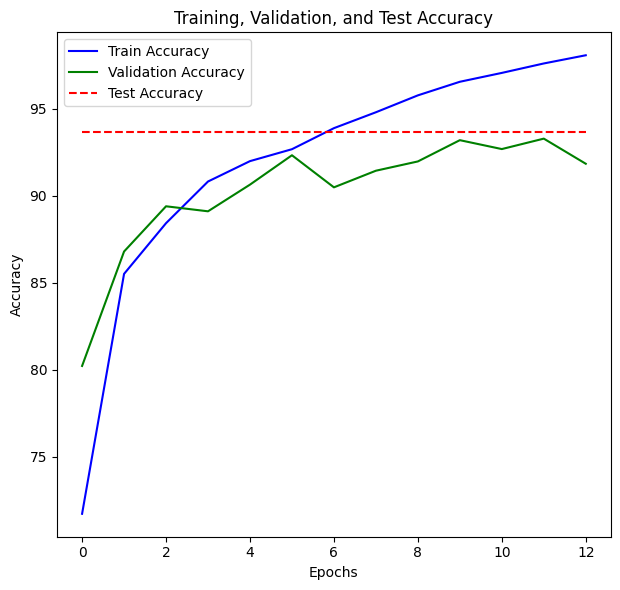

In [72]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_es = [test_accuracy_es * 100] * len(train_acc_es)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_es)), train_acc_es, label="Train Accuracy", color='b')
plt.plot(range(len(train_acc_es)), validation_acc_es, label="Validation Accuracy", color='g')
plt.plot(range(len(train_acc_es)), test_acc_es, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

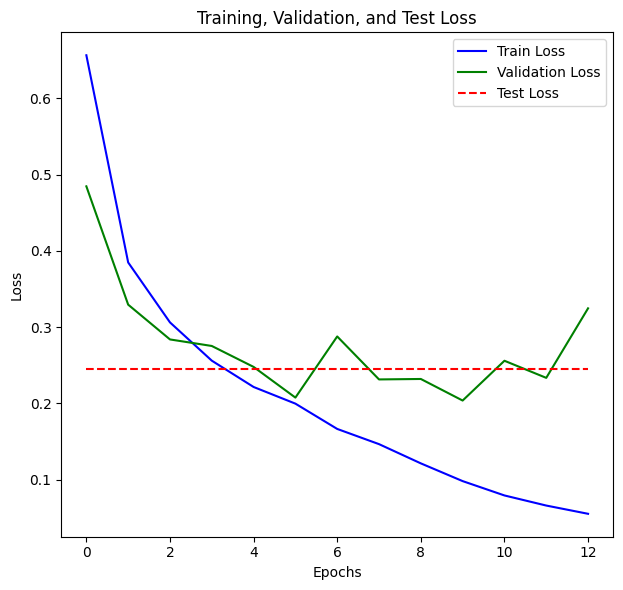

In [73]:
test_loss_es = [test_loss_es] * len(train_acc_es)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_es)), train_loss_es, label="Train Loss", color='b')
plt.plot(range(len(train_acc_es)), validation_loss_es, label="Validation Loss", color='g')
plt.plot(range(len(train_acc_es)), test_loss_es, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

#### ii) Image Augmentation + Early stopping

In [79]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),  
    transforms.RandomHorizontalFlip(), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5], std=[0.5])  
])

# For val/test dataset
val_transforms = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize(mean=[0.5], std=[0.5])
])


In [80]:
# Splitting the dataset into train, validation, and test sets
train_dataset_reg, val_dataset_reg, test_dataset_reg = random_split(data, [train_size, val_size, test_size])

In [81]:
train_dataset_reg.transform = train_transforms

In [82]:
print(batch_size)

64


In [83]:
# DataLoaders for training, validation, and test sets
train_loader_aug = DataLoader(train_dataset_reg, batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_reg, batch_size, shuffle=False)
test_loader_aug = DataLoader(test_dataset_reg, batch_size, shuffle=False)

In [84]:
model_aug = VGG16Imp(init_method='kaiming').to(device)

In [85]:
loss_fn_aug = nn.CrossEntropyLoss()
optimizer_aug = torch.optim.AdamW(model_aug.parameters(), lr=3e-4)
scheduler_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_aug, mode='min', patience=3, factor=0.1)

In [86]:
start_time = time.time()
train_acc_aug = []
validation_acc_aug = []
train_loss_aug = []
validation_loss_aug = []

best_loss = float("inf")
patience_counter = 0 
patience = 5

for t in range(epochs):
    loss, acc = train_loop(train_loader_aug, model_aug, loss_fn_aug, optimizer_aug)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader_aug, model_aug, loss_fn_aug)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")
    
    if v_loss < best_loss:
        best_loss = v_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience:
        print(f"Early stopping! Training stopped after {t} epochs")
        break
    scheduler_es.step(v_loss)

    train_acc_aug.append(acc)
    validation_acc_aug.append(v_acc)
    train_loss_aug.append(loss)
    validation_loss_aug.append(v_loss)


# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_aug.state_dict():
#     print(param_tensor, "\t", model_aug.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_aug)/len(train_acc_aug))

print("Validation accuracy is", sum(validation_acc_aug)/len(validation_acc_aug))

Epoch [1/20], Loss: 0.685, Accuracy: 73.33%
Epoch [1/20], Validation Loss: 0.429, Validation Accuracy: 84.51%
Epoch [2/20], Loss: 0.388, Accuracy: 85.47%
Epoch [2/20], Validation Loss: 0.348, Validation Accuracy: 86.40%
Epoch [3/20], Loss: 0.309, Accuracy: 88.47%
Epoch [3/20], Validation Loss: 0.279, Validation Accuracy: 89.73%
Epoch [4/20], Loss: 0.260, Accuracy: 90.50%
Epoch [4/20], Validation Loss: 0.255, Validation Accuracy: 90.98%
Epoch [5/20], Loss: 0.225, Accuracy: 91.85%
Epoch [5/20], Validation Loss: 0.267, Validation Accuracy: 91.47%
No improvement for 1 epochs.
Epoch [6/20], Loss: 0.207, Accuracy: 92.63%
Epoch [6/20], Validation Loss: 0.340, Validation Accuracy: 87.51%
No improvement for 2 epochs.
Epoch [7/20], Loss: 0.180, Accuracy: 93.58%
Epoch [7/20], Validation Loss: 0.256, Validation Accuracy: 90.44%
No improvement for 3 epochs.
Epoch [8/20], Loss: 0.138, Accuracy: 95.06%
Epoch [8/20], Validation Loss: 0.249, Validation Accuracy: 92.27%
Epoch [9/20], Loss: 0.119, Accura

In [87]:
test_loss_aug , test_accuracy_aug = 0,0
actual_values_aug = []
predicted_val_aug = []
test_loss_aug, test_accuracy_aug, actual_values_aug, predicted_val_aug = test_loop(test_loader_aug, model_aug, loss_fn_aug)

Test Accuracy: 0.9251111111111111, Precision: 0.9258747233575525, Recall: 0.9251111111111111, F1 Score: 0.9248848879243768
Test loss is 0.33196082721713566


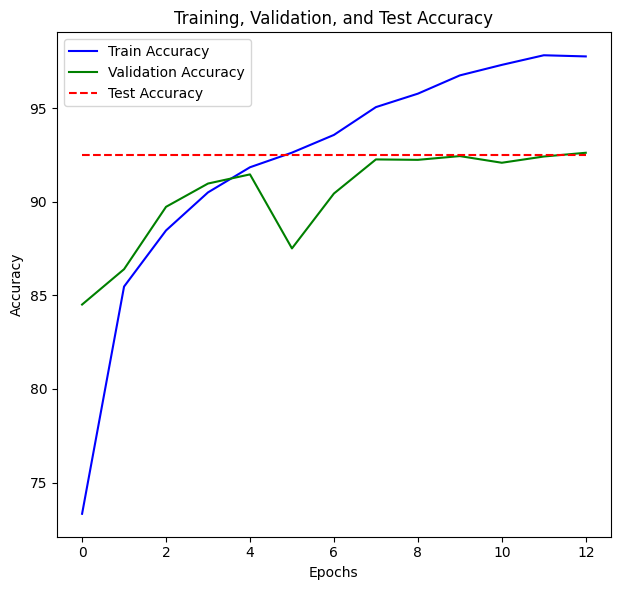

In [89]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_aug = [test_accuracy_aug * 100] * len(train_acc_aug)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_aug)), train_acc_aug, label="Train Accuracy", color='b')
plt.plot(range(len(train_acc_aug)), validation_acc_aug, label="Validation Accuracy", color='g')
plt.plot(range(len(train_acc_aug)), test_acc_aug, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

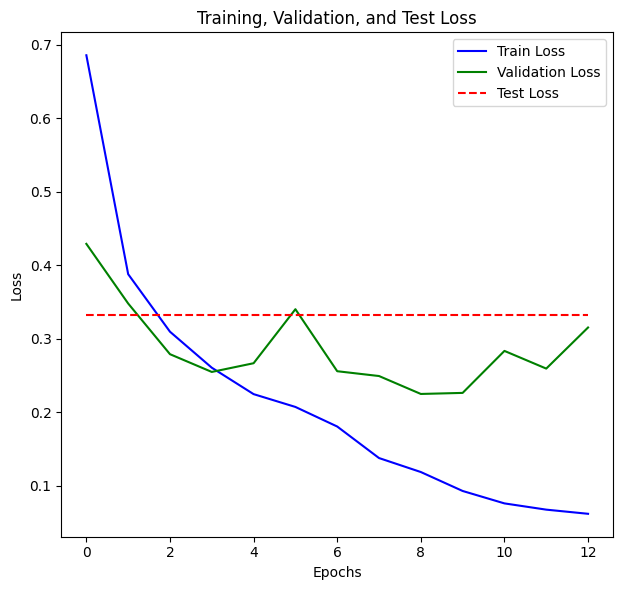

In [90]:
test_loss_aug = [test_loss_aug] * len(train_loss_aug)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss_aug)), train_loss_aug, label="Train Loss", color='b')
plt.plot(range(len(train_loss_aug)), validation_loss_aug, label="Validation Loss", color='g')
plt.plot(range(len(train_loss_aug)), test_loss_aug, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

#### iii) L2 regularization + image augmentation + early stopping (Best Model)

### Best Model VGG

Batch size = 64 <br>
loss_fn = AdamW <br>
lr = 3e-04 <br>
weight decay + augmentation + early stopping

In [108]:
from torch.utils.tensorboard import SummaryWriter

In [109]:
model_reg = VGG16Imp(init_method='kaiming').to(device)

In [110]:
loss_fn_reg = nn.CrossEntropyLoss()
optimizer_reg = torch.optim.AdamW(model_reg.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_reg = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', patience=3, factor=0.1)

In [111]:
writer = SummaryWriter('runs/vgg_fin')

start_time = time.time()
train_acc_reg = []
validation_acc_reg = []
train_loss_reg = []
validation_loss_reg = []

best_loss = float("inf")
patience_counter = 0 
patience = 4

for t in range(epochs):
    loss, acc = train_loop(train_loader, model_reg, loss_fn_reg, optimizer_reg)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_reg, loss_fn_reg)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    if v_loss < best_loss:
        best_loss = v_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience:
        print(f"Early stopping! Training stopped after {t} epochs")
        break
    scheduler_es.step(v_loss)

    train_acc_reg.append(acc)
    validation_acc_reg.append(v_acc)
    train_loss_reg.append(loss)
    validation_loss_reg.append(v_loss)
    # Logging metrics to TensorBoard
    writer.add_scalar('Loss/train', loss, t)
    writer.add_scalar('Loss/val', v_loss, t)
    writer.add_scalar('Accuracy/train', acc, t)
    writer.add_scalar('Accuracy/val', v_acc, t)

writer.close()

# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_reg.state_dict():
#     print(param_tensor, "\t", model_reg.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_reg)/len(train_acc_reg))

print("Validation accuracy is", sum(validation_acc_reg)/len(validation_acc_reg))

Epoch [1/20], Loss: 0.655, Accuracy: 72.01%
Epoch [1/20], Validation Loss: 0.473, Validation Accuracy: 82.36%
Epoch [2/20], Loss: 0.373, Accuracy: 85.93%
Epoch [2/20], Validation Loss: 0.294, Validation Accuracy: 89.64%
Epoch [3/20], Loss: 0.303, Accuracy: 89.15%
Epoch [3/20], Validation Loss: 0.257, Validation Accuracy: 90.11%
Epoch [4/20], Loss: 0.259, Accuracy: 90.52%
Epoch [4/20], Validation Loss: 0.257, Validation Accuracy: 90.13%
No improvement for 1 epochs.
Epoch [5/20], Loss: 0.220, Accuracy: 91.74%
Epoch [5/20], Validation Loss: 0.270, Validation Accuracy: 90.13%
No improvement for 2 epochs.
Epoch [6/20], Loss: 0.180, Accuracy: 93.53%
Epoch [6/20], Validation Loss: 0.202, Validation Accuracy: 92.60%
Epoch [7/20], Loss: 0.171, Accuracy: 93.99%
Epoch [7/20], Validation Loss: 0.257, Validation Accuracy: 90.82%
No improvement for 1 epochs.
Epoch [8/20], Loss: 0.134, Accuracy: 95.15%
Epoch [8/20], Validation Loss: 0.190, Validation Accuracy: 93.27%
Epoch [9/20], Loss: 0.111, Accura

In [112]:
test_loss_reg , test_accuracy_reg = 0,0
actual_values_reg = []
predicted_val_reg = []
test_loss_reg, test_accuracy_reg, actual_values_reg, predicted_val_reg = test_loop(test_loader, model_reg, loss_fn_reg)

Test Accuracy: 0.9373333333333334, Precision: 0.9374244145032883, Recall: 0.9373333333333334, F1 Score: 0.9373226646873922
Test loss is 0.23984664933375593


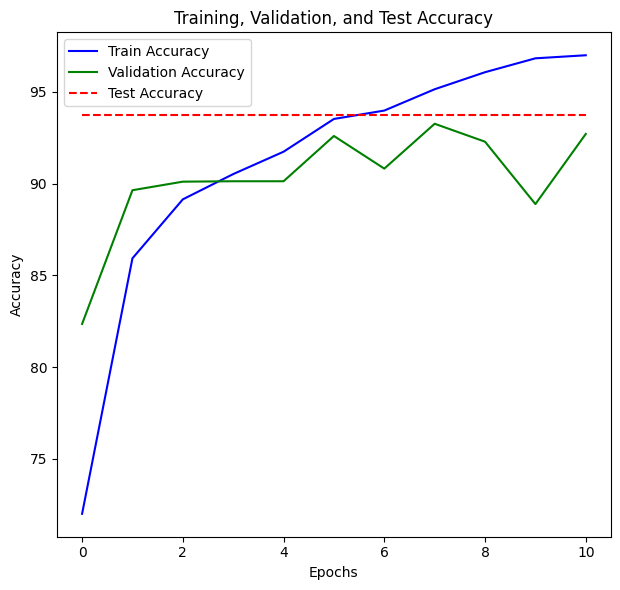

In [113]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_reg = [test_accuracy_reg * 100] * len(train_acc_reg)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_reg)), train_acc_reg, label="Train Accuracy", color='b')
plt.plot(range(len(train_acc_reg)), validation_acc_reg, label="Validation Accuracy", color='g')
plt.plot(range(len(train_acc_reg)), test_acc_reg, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

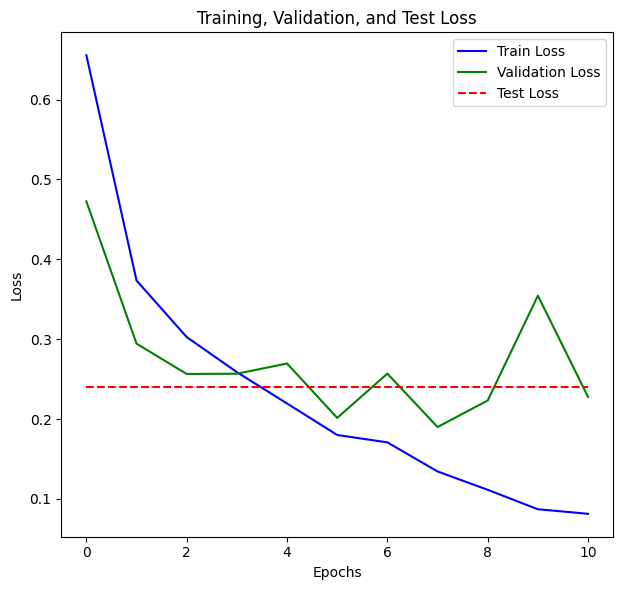

In [114]:
test_loss_reg = [test_loss_reg] * len(train_loss_reg)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss_reg)), train_loss_reg, label="Train Loss", color='b')
plt.plot(range(len(train_loss_reg)), validation_loss_reg, label="Validation Loss", color='g')
plt.plot(range(len(train_loss_reg)), test_loss_reg, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

The model demonstrated strong generalization with an accuracy of 93.78% on the test set and a lesser test loss of 0.319 compared to base model's 0.421. The use of early stopping, weight decay(l2 regularization), and data augmentation contributed to improved performance and reduced overfitting.

#### Evaluation and Analysis

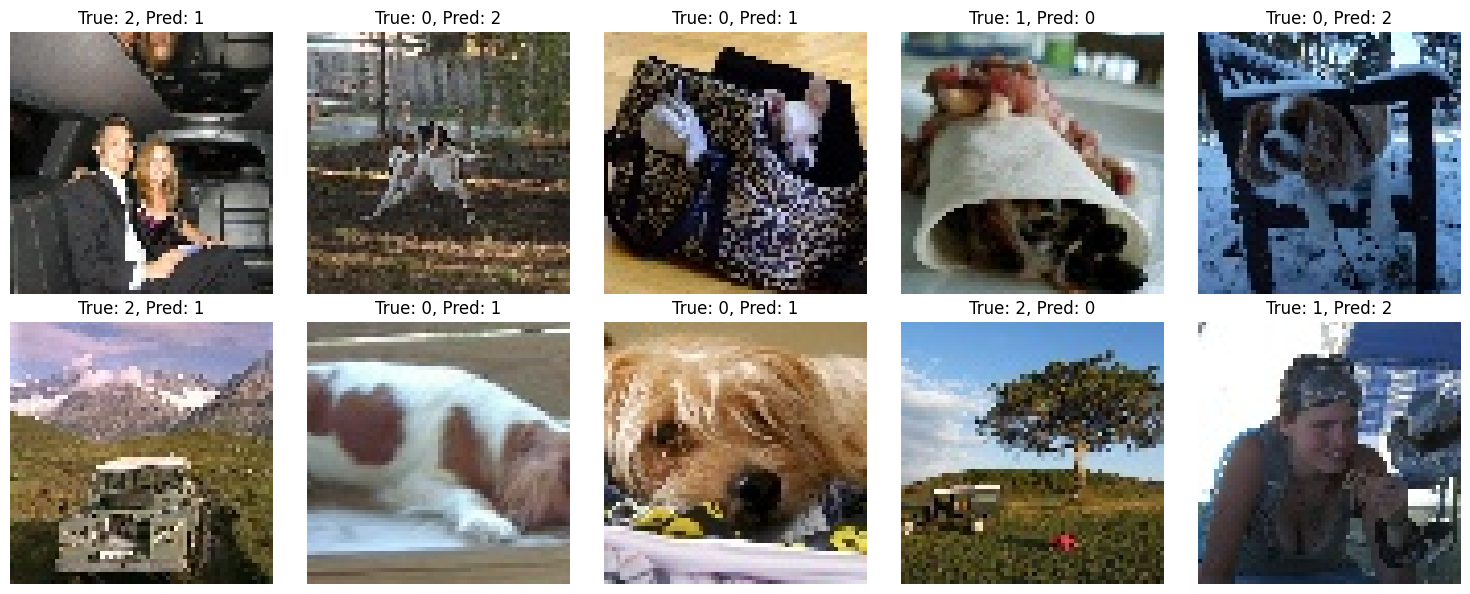

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def display_misclassified_images(dataloader, model, actual, predictions, num_to_display=10, grid_size=(2, 5)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    #Since we didn't keep track of predicted images and/or misclassified images in the training, we will have to predict it once more using the model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # Identifying misclassified samples
            misclassified = predicted != labels
            misclassified_images.extend(inputs[misclassified].cpu())
            misclassified_labels.extend(labels[misclassified].cpu())
            misclassified_preds.extend(predicted[misclassified].cpu())

            # We only take 10 images
            if len(misclassified_images) >= num_to_display:
                break

    # Display misclassified images in a grid
    num_misclassified = len(misclassified_images)
    no_images_display = min(num_misclassified, num_to_display)
    # print(f"Displaying {num_misclassified} misclassified images in a grid.")

    # Create a grid of subplots
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 6))
    axes = axes.flatten()

    # Display the misclassified images
    for i in range(no_images_display):
        ax = axes[i]
        ax.imshow(misclassified_images[i].permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        ax.set_title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
        ax.axis('off')  # Hide axis

    # Remove any extra subplots if there are less images than grid size
    for i in range(num_misclassified, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

        
display_misclassified_images(test_loader, model_reg, actual_values_reg, predicted_val_reg, num_to_display=10)

### Why model moght have misclassified images

The model may have misclassified the images due to similarities in distinguishing features. For example, certain food items share shape characteristics with smaller dogs, especially when viewed from ambiguous angles, and vice versa.

In [213]:
from IPython.display import display, HTML  
import os

def show_svg(directory, width=400, height=400):
    svg_files = [f for f in os.listdir(directory) if f.endswith(".svg")]
    
    for svg_file in svg_files:
        file_path = os.path.join(directory, svg_file)
        print(f"Displaying: {svg_file}")
        
        # Create HTML img element with specified dimensions
        display_html = f'<img src="{file_path}" width="{width}" height="{height}">'
        display(HTML(display_html))  

        
directory = "SVG files/vgg" 
show_svg(directory)

Displaying: Loss_val_vgg.svg


Displaying: Accuracy_train_vgg.svg


Displaying: Accuracy_val_vgg.svg


Displaying: Loss_train_vgg.svg


In [129]:
torch.save(model_reg.state_dict(), './a1_weights_vgg16_ha33_siyer8.pt')

### Best model VGG discussion

Early stopping! Training stopped after 11 epochs<br>
Training completed in: 652.22 seconds<br>
Training accuracy is 91.08441558441558<br>
Validation accuracy is 90.26868686868687<br>
Test Accuracy: 0.9373333333333334, Precision: 0.9374244145032883, Recall: 0.9373333333333334, F1 Score: 0.9373226646873922
Test loss is 0.23984664933375593<br>


The model exhibited consistent improvements in accuracy over the epochs, with training accuracy reaching 97.00% and validation accuracy peaking at 93.31%. However, validation loss started increasing after the 6th epoch, signaling potential overfitting. <br>
Early stopping was triggered after four consecutive epochs without improvement, halting training at the 11th epoch. The final recorded training accuracy was 91.08%, with a validation accuracy of 90.27%. <br>
Despite slight fluctuations in validation accuracy, the model maintained strong generalization. The test results further confirmed its performance, achieving an accuracy of 93.73%, precision of 93.74%, recall of 93.73%, and an F1-score of 93.73%. The final test loss was 0.2398. <br>
The implementation of early stopping, alongside techniques like weight decay (L2 regularization) and data augmentation, helped mitigate overfitting while ensuring robust performance on unseen data.

## Implementing ResNet

In [130]:
class ResidualBlock(nn.Module):
    def __init__(self, input_layers, out_layers, stride=1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_layers, out_layers, kernel_size=3, padding=1, stride=stride)  
        self.norm1 = nn.BatchNorm2d(out_layers)  
        self.conv2 = nn.Conv2d(out_layers, out_layers, kernel_size=3, padding=1, stride=1)
        self.norm2 = nn.BatchNorm2d(out_layers)  
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        if self.downsample is not None: ## Downsampling if input and output sizes don't match
            identity = self.downsample(x)
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.norm2(y)
        
        y+=identity
        y = self.relu(y)
        return y


In [131]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=3, init_method='kaiming'):
        super(ResNet18, self).__init__()
        self.input_layers = 64
        self.conv1 = nn.Conv2d(3, self.input_layers, kernel_size=7, padding=3, stride=2)
        self.norm1 = nn.BatchNorm2d(self.input_layers)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #Creating residual blocks for every layer size
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

         # Apply weight initialization
        self._initialize_weights(init_method)

    #This function creates a residual block layer with optional downsampling for a deep neural network.
    def _make_layer(self, out_layers, blocks, stride):
        downsample = None
        if stride != 1 or self.input_layers != out_layers:
            downsample = nn.Sequential(
                nn.Conv2d(self.input_layers, out_layers, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_layers)
            )
        
        layers = []
        layers.append(ResidualBlock(self.input_layers, out_layers, stride, downsample))
        self.input_layers = out_layers
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_layers, out_layers))
        
        return nn.Sequential(*layers)
        
    def _initialize_weights(self, init_method):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if init_method == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif init_method == 'kaiming':
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                    
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)  # Set biases to 0
               
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


In [219]:
model_res_sum = ResNet18().to(device)

In [220]:
summary(model_res_sum, (64,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [64, 3]                   --
├─Conv2d: 1-1                            [64, 64, 32, 32]          9,472
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]          128
├─ReLU: 1-3                              [64, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [64, 64, 16, 16]          --
├─Sequential: 1-5                        [64, 64, 16, 16]          --
│    └─ResidualBlock: 2-1                [64, 64, 16, 16]          --
│    │    └─Conv2d: 3-1                  [64, 64, 16, 16]          36,928
│    │    └─BatchNorm2d: 3-2             [64, 64, 16, 16]          128
│    │    └─ReLU: 3-3                    [64, 64, 16, 16]          --
│    │    └─Conv2d: 3-4                  [64, 64, 16, 16]          36,928
│    │    └─BatchNorm2d: 3-5             [64, 64, 16, 16]          128
│    │    └─ReLU: 3-6                    [64, 64, 16, 16]          --
│

#### SGD optimizer

In [132]:
model_1 = ResNet18(init_method='kaiming').to(device)

In [133]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=3e-4, momentum=0.9)
scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_kaiming, mode='min', patience=3, factor=0.1)

In [134]:
start_time = time.time()
train_acc_1 = []
validation_acc_1 = []
train_loss_1 = []
validation_loss_1 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_1, loss_fn_1, optimizer_1)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_1, loss_fn_1)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_1.step(v_loss)
    
    train_acc_1.append(acc)
    validation_acc_1.append(v_acc)
    train_loss_1.append(loss)
    validation_loss_1.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_1.state_dict():
#     print(param_tensor, "\t", model_1.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_1)/len(train_acc_1))

print("Validation accuracy is", sum(validation_acc_1)/len(validation_acc_1))

Epoch [1/20], Loss: 0.661, Accuracy: 71.59%
Epoch [1/20], Validation Loss: 0.522, Validation Accuracy: 78.62%
Epoch [2/20], Loss: 0.420, Accuracy: 83.55%
Epoch [2/20], Validation Loss: 0.442, Validation Accuracy: 81.87%
Epoch [3/20], Loss: 0.327, Accuracy: 87.63%
Epoch [3/20], Validation Loss: 0.432, Validation Accuracy: 82.42%
Epoch [4/20], Loss: 0.255, Accuracy: 90.89%
Epoch [4/20], Validation Loss: 0.413, Validation Accuracy: 83.80%
Epoch [5/20], Loss: 0.196, Accuracy: 93.38%
Epoch [5/20], Validation Loss: 0.410, Validation Accuracy: 84.22%
Epoch [6/20], Loss: 0.145, Accuracy: 95.70%
Epoch [6/20], Validation Loss: 0.427, Validation Accuracy: 84.38%
Epoch [7/20], Loss: 0.106, Accuracy: 97.39%
Epoch [7/20], Validation Loss: 0.429, Validation Accuracy: 84.07%
Epoch [8/20], Loss: 0.074, Accuracy: 98.59%
Epoch [8/20], Validation Loss: 0.446, Validation Accuracy: 83.91%
Epoch [9/20], Loss: 0.057, Accuracy: 99.11%
Epoch [9/20], Validation Loss: 0.462, Validation Accuracy: 84.36%
Epoch [10/

In [135]:
test_loss_1 , test_accuracy_1 = 0,0
actual_values_1 = []
predicted_val_1 = []
test_loss_1, test_accuracy_1, actual_values_1, predicted_val_1 = test_loop(test_loader, model_1, loss_fn_1)

Test Accuracy: 0.8493333333333334, Precision: 0.8488907119443988, Recall: 0.8493333333333334, F1 Score: 0.8487043729805337
Test loss is 0.564588339815677


#### Adam optimizer

In [136]:
model_2 = ResNet18(init_method='kaiming').to(device)

In [137]:
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=3e-4)
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_kaiming, mode='min', patience=3, factor=0.1)

In [138]:
start_time = time.time()
train_acc_2 = []
validation_acc_2 = []
train_loss_2 = []
validation_loss_2 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_2, loss_fn_2, optimizer_2)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_2, loss_fn_2)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_2.step(v_loss)
    
    train_acc_2.append(acc)
    validation_acc_2.append(v_acc)
    train_loss_2.append(loss)
    validation_loss_2.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_2.state_dict():
#     print(param_tensor, "\t", model_2.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_2)/len(train_acc_2))

print("Validation accuracy is", sum(validation_acc_2)/len(validation_acc_2))

Epoch [1/20], Loss: 0.464, Accuracy: 81.87%
Epoch [1/20], Validation Loss: 0.459, Validation Accuracy: 82.76%
Epoch [2/20], Loss: 0.278, Accuracy: 89.56%
Epoch [2/20], Validation Loss: 0.408, Validation Accuracy: 85.13%
Epoch [3/20], Loss: 0.211, Accuracy: 92.00%
Epoch [3/20], Validation Loss: 0.601, Validation Accuracy: 81.11%
Epoch [4/20], Loss: 0.143, Accuracy: 94.63%
Epoch [4/20], Validation Loss: 0.452, Validation Accuracy: 86.38%
Epoch [5/20], Loss: 0.108, Accuracy: 96.00%
Epoch [5/20], Validation Loss: 0.621, Validation Accuracy: 83.58%
Epoch [6/20], Loss: 0.098, Accuracy: 96.37%
Epoch [6/20], Validation Loss: 0.675, Validation Accuracy: 82.11%
Epoch [7/20], Loss: 0.068, Accuracy: 97.50%
Epoch [7/20], Validation Loss: 0.494, Validation Accuracy: 87.40%
Epoch [8/20], Loss: 0.052, Accuracy: 98.07%
Epoch [8/20], Validation Loss: 0.721, Validation Accuracy: 82.31%
Epoch [9/20], Loss: 0.044, Accuracy: 98.39%
Epoch [9/20], Validation Loss: 0.432, Validation Accuracy: 88.18%
Epoch [10/

In [139]:
test_loss_2 , test_accuracy_2 = 0,0
actual_values_2 = []
predicted_val_2 = []
test_loss_2, test_accuracy_2, actual_values_2, predicted_val_2 = test_loop(test_loader, model_2, loss_fn_2)

Test Accuracy: 0.8742222222222222, Precision: 0.8781523140333576, Recall: 0.8742222222222222, F1 Score: 0.8731486878755246
Test loss is 0.6056796017457062


#### AdamW

In [140]:
model_3 = ResNet18(init_method='kaiming').to(device)

In [141]:
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.AdamW(model_3.parameters(), lr=3e-4)
scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_kaiming, mode='min', patience=3, factor=0.1)

In [142]:
start_time = time.time()
train_acc_3 = []
validation_acc_3 = []
train_loss_3 = []
validation_loss_3 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader, model_3, loss_fn_3, optimizer_3)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader, model_3, loss_fn_3)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_3.step(v_loss)
    
    train_acc_3.append(acc)
    validation_acc_3.append(v_acc)
    train_loss_3.append(loss)
    validation_loss_3.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_3.state_dict():
#     print(param_tensor, "\t", model_3.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_3)/len(train_acc_3))

print("Validation accuracy is", sum(validation_acc_3)/len(validation_acc_3))

Epoch [1/20], Loss: 0.468, Accuracy: 81.65%
Epoch [1/20], Validation Loss: 0.425, Validation Accuracy: 83.82%
Epoch [2/20], Loss: 0.286, Accuracy: 88.86%
Epoch [2/20], Validation Loss: 0.431, Validation Accuracy: 84.29%
Epoch [3/20], Loss: 0.196, Accuracy: 92.65%
Epoch [3/20], Validation Loss: 0.319, Validation Accuracy: 88.78%
Epoch [4/20], Loss: 0.143, Accuracy: 94.50%
Epoch [4/20], Validation Loss: 0.329, Validation Accuracy: 88.51%
Epoch [5/20], Loss: 0.100, Accuracy: 96.31%
Epoch [5/20], Validation Loss: 0.814, Validation Accuracy: 78.64%
Epoch [6/20], Loss: 0.086, Accuracy: 96.81%
Epoch [6/20], Validation Loss: 0.502, Validation Accuracy: 86.78%
Epoch [7/20], Loss: 0.075, Accuracy: 97.26%
Epoch [7/20], Validation Loss: 0.475, Validation Accuracy: 85.73%
Epoch [8/20], Loss: 0.045, Accuracy: 98.39%
Epoch [8/20], Validation Loss: 0.469, Validation Accuracy: 87.67%
Epoch [9/20], Loss: 0.043, Accuracy: 98.50%
Epoch [9/20], Validation Loss: 0.608, Validation Accuracy: 85.29%
Epoch [10/

In [143]:
test_loss_3 , test_accuracy_3 = 0,0
actual_values_3 = []
predicted_val_3 = []
test_loss_3, test_accuracy_3, actual_values_3, predicted_val_3 = test_loop(test_loader, model_3, loss_fn_3)

Test Accuracy: 0.886, Precision: 0.8861723175957094, Recall: 0.886, F1 Score: 0.8860624591895356
Test loss is 0.45658489102891214


### Discussion on optimizer

From the data above, we can see that **AdamW** performs the best out of **SGD**, **Adam**, and **AdamW**.<br>

**SGD** reaches 95.78% training accuracy and 84.16% validation accuracy. Despite its fast convergence, the test loss is 0.5645.<br>
**AdamW** reaches 96.55% training accuracy and 86.71% validation accuracy, which indicates better generalization, despite slightly slower convergence compared to Adam. The test loss is 0.4566.<br>
**Adam** reaches 96.57% training accuracy and 86.48% validation accuracy. The test loss is 0.6057.<br>

Although **Adam** reaches the highest training accuracy, its validation accuracy of 86.48% and higher test loss of 0.6057 make it less favorable. Therefore, **AdamW** is the optimal choice due to its superior generalization and minimal test loss.

#### Batch size = 32

In [148]:
model_5 = ResNet18(init_method='kaiming').to(device)

In [149]:
loss_fn_5 = nn.CrossEntropyLoss()
optimizer_5 = torch.optim.AdamW(model_5.parameters(), lr=3e-4)
scheduler_5 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_kaiming, mode='min', patience=3, factor=0.1)

In [150]:
start_time = time.time()
train_acc_5 = []
validation_acc_5 = []
train_loss_5 = []
validation_loss_5 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader_size32, model_5, loss_fn_5, optimizer_5)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader_size32, model_5, loss_fn_5)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_5.step(v_loss)
    
    train_acc_5.append(acc)
    validation_acc_5.append(v_acc)
    train_loss_5.append(loss)
    validation_loss_5.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_5.state_dict():
#     print(param_tensor, "\t", model_5.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_5)/len(train_acc_5))

print("Validation accuracy is", sum(validation_acc_5)/len(validation_acc_5))

Epoch [1/20], Loss: 0.467, Accuracy: 81.55%
Epoch [1/20], Validation Loss: 0.406, Validation Accuracy: 84.71%
Epoch [2/20], Loss: 0.303, Accuracy: 88.50%
Epoch [2/20], Validation Loss: 0.338, Validation Accuracy: 87.42%
Epoch [3/20], Loss: 0.232, Accuracy: 91.24%
Epoch [3/20], Validation Loss: 0.606, Validation Accuracy: 80.49%
Epoch [4/20], Loss: 0.177, Accuracy: 93.58%
Epoch [4/20], Validation Loss: 0.382, Validation Accuracy: 87.11%
Epoch [5/20], Loss: 0.132, Accuracy: 95.08%
Epoch [5/20], Validation Loss: 0.411, Validation Accuracy: 86.09%
Epoch [6/20], Loss: 0.098, Accuracy: 96.26%
Epoch [6/20], Validation Loss: 0.340, Validation Accuracy: 89.60%
Epoch [7/20], Loss: 0.079, Accuracy: 97.10%
Epoch [7/20], Validation Loss: 0.357, Validation Accuracy: 89.20%
Epoch [8/20], Loss: 0.063, Accuracy: 97.70%
Epoch [8/20], Validation Loss: 0.599, Validation Accuracy: 85.24%
Epoch [9/20], Loss: 0.063, Accuracy: 97.80%
Epoch [9/20], Validation Loss: 0.440, Validation Accuracy: 88.13%
Epoch [10/

In [151]:
test_loss_5 , test_accuracy_5 = 0,0
actual_values_5 = []
predicted_val_5 = []
test_loss_5, test_accuracy_5, actual_values_5, predicted_val_5 = test_loop(test_loader_size32, model_5, loss_fn_5)

Test Accuracy: 0.8877777777777778, Precision: 0.8890909102561543, Recall: 0.8877777777777778, F1 Score: 0.888009348327318
Test loss is 0.44244500692167604


#### Batch size = 128

In [152]:
model_6 = ResNet18(init_method='kaiming').to(device)

In [153]:
loss_fn_6 = nn.CrossEntropyLoss()
optimizer_6 = torch.optim.AdamW(model_6.parameters(), lr=3e-4)
scheduler_6 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_kaiming, mode='min', patience=3, factor=0.1)

In [154]:
start_time = time.time()
train_acc_6 = []
validation_acc_6 = []
train_loss_6 = []
validation_loss_6 = []
for t in range(epochs):
    loss, acc = train_loop(train_loader_size128, model_6, loss_fn_6, optimizer_6)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader_size128, model_6, loss_fn_6)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")

    scheduler_6.step(v_loss)
    
    train_acc_6.append(acc)
    validation_acc_6.append(v_acc)
    train_loss_6.append(loss)
    validation_loss_6.append(v_loss)

     
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_6.state_dict():
#     print(param_tensor, "\t", model_6.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_6)/len(train_acc_6))

print("Validation accuracy is", sum(validation_acc_6)/len(validation_acc_6))

Epoch [1/20], Loss: 0.467, Accuracy: 81.61%
Epoch [1/20], Validation Loss: 0.363, Validation Accuracy: 85.76%
Epoch [2/20], Loss: 0.261, Accuracy: 89.98%
Epoch [2/20], Validation Loss: 0.554, Validation Accuracy: 81.09%
Epoch [3/20], Loss: 0.146, Accuracy: 94.71%
Epoch [3/20], Validation Loss: 0.654, Validation Accuracy: 83.40%
Epoch [4/20], Loss: 0.130, Accuracy: 95.03%
Epoch [4/20], Validation Loss: 0.524, Validation Accuracy: 84.07%
Epoch [5/20], Loss: 0.079, Accuracy: 97.03%
Epoch [5/20], Validation Loss: 0.541, Validation Accuracy: 86.44%
Epoch [6/20], Loss: 0.060, Accuracy: 97.87%
Epoch [6/20], Validation Loss: 0.523, Validation Accuracy: 86.07%
Epoch [7/20], Loss: 0.031, Accuracy: 98.86%
Epoch [7/20], Validation Loss: 0.740, Validation Accuracy: 84.42%
Epoch [8/20], Loss: 0.057, Accuracy: 98.26%
Epoch [8/20], Validation Loss: 0.536, Validation Accuracy: 86.64%
Epoch [9/20], Loss: 0.075, Accuracy: 97.22%
Epoch [9/20], Validation Loss: 0.571, Validation Accuracy: 87.29%
Epoch [10/

In [155]:
test_loss_6 , test_accuracy_6 = 0,0
actual_values_6 = []
predicted_val_6 = []
test_loss_6, test_accuracy_6, actual_values_6, predicted_val_6 = test_loop(test_loader_size128, model_6, loss_fn_6)

Test Accuracy: 0.8384444444444444, Precision: 0.8503811617392365, Recall: 0.8384444444444444, F1 Score: 0.838336087566266
Test loss is 0.7074766051438119


### Discussion on batch size

From the results, we can see that **Batch size 32** performs the best in terms of test accuracy compared to batch sizes 64 and 128. With batch size 32, we achieve a training accuracy of over 96% and a test accuracy of over 88%, with a training time of 983.43 seconds. The test loss is 0.442. <br>
On the other hand, with **batch size 64**, we still obtain a training accuracy of over 96% and a test accuracy of 88.60%, but the training time is much faster at 530.53 seconds. The test loss is 0.457. <br>
Lastly, **batch size 128** yields a training accuracy of over 96% and a test accuracy of 83.84%, with the fastest training time of 364.92 seconds. The test loss is 0.707. <br>
Depending on the priority, either **batch size 32 or 64** could be selected: batch size 32 for better test accuracy or batch size 64 for a good balance of speed and performance. So we would be selecting **batch size 64** for the balance

In [161]:
print(batch_size)

64


### Best Model- Image augmentation + early stopping + weight decay

Batch size = 64 <br>
loss_fn = AdamW <br>
lr = 1e-03 <br>
weight decay + augmentation + early stopping

In [162]:
from torch.utils.tensorboard import SummaryWriter

In [178]:
# DataLoaders for training, validation, and test sets
train_loader_aug_res = DataLoader(train_dataset_reg, batch_size, shuffle=True)
val_loader_aug_res = DataLoader(val_dataset_reg, batch_size, shuffle=False)
test_loader_aug_res = DataLoader(test_dataset_reg, batch_size, shuffle=False)

In [179]:
model_fin_resnet = ResNet18(init_method='kaiming').to(device)

In [180]:
loss_fn_fin_resnet = nn.CrossEntropyLoss()
optimizer_fin_resnet = torch.optim.AdamW(model_fin_resnet.parameters(), lr=1e-03,weight_decay=1e-4)
scheduler_fin_resnet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fin_resnet, mode='min', patience=3, factor=0.1)

In [181]:
epochs_res = 30

In [182]:
writer = SummaryWriter('runs/resnet_fin')

start_time = time.time()
train_acc_fin_resnet = []
validation_acc_fin_resnet = []
train_loss_fin_resnet = []
validation_loss_fin_resnet = []

best_loss = float("inf")
patience_counter = 0 
patience = 8

for t in range(epochs_res):
    loss, acc = train_loop(train_loader_aug_res, model_fin_resnet, loss_fn_fin_resnet, optimizer_fin_resnet)
    print(f"Epoch [{t+1}/{epochs}], Loss: {loss:.3f}, Accuracy: {acc:.2f}%")
    v_loss, v_acc = validation_loop(val_loader_aug_res, model_fin_resnet, loss_fn_fin_resnet)
    print(f"Epoch [{t+1}/{epochs}], Validation Loss: {v_loss:.3f}, Validation Accuracy: {v_acc:.2f}%")
       # Early stopping 
    if v_loss < best_loss:
        best_loss = v_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience:
        print(f"Early stopping! Training stopped after {t} epochs")
        break
    scheduler_fin_resnet.step(v_loss)

    train_acc_fin_resnet.append(acc)
    validation_acc_fin_resnet.append(v_acc)
    train_loss_fin_resnet.append(loss)
    validation_loss_fin_resnet.append(v_loss)
    # Logging metrics to TensorBoard
    writer.add_scalar('Loss/train', loss, t)
    writer.add_scalar('Loss/val', v_loss, t)
    writer.add_scalar('Accuracy/train', acc, t)
    writer.add_scalar('Accuracy/val', v_acc, t)

writer.close()
# Total time taken for training
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model_fin_resnet.state_dict():
#     print(param_tensor, "\t", model_fin_resnet.state_dict()[param_tensor].size())


print("Training accuracy is", sum(train_acc_fin_resnet)/len(train_acc_fin_resnet))

print("Validation accuracy is", sum(validation_acc_fin_resnet)/len(validation_acc_fin_resnet))

Epoch [1/20], Loss: 0.452, Accuracy: 82.96%
Epoch [1/20], Validation Loss: 0.447, Validation Accuracy: 83.44%
Epoch [2/20], Loss: 0.308, Accuracy: 88.45%
Epoch [2/20], Validation Loss: 0.351, Validation Accuracy: 86.49%
Epoch [3/20], Loss: 0.251, Accuracy: 90.61%
Epoch [3/20], Validation Loss: 0.340, Validation Accuracy: 87.91%
Epoch [4/20], Loss: 0.220, Accuracy: 91.83%
Epoch [4/20], Validation Loss: 0.265, Validation Accuracy: 90.38%
Epoch [5/20], Loss: 0.178, Accuracy: 93.33%
Epoch [5/20], Validation Loss: 0.843, Validation Accuracy: 77.18%
No improvement for 1 epochs.
Epoch [6/20], Loss: 0.143, Accuracy: 94.67%
Epoch [6/20], Validation Loss: 0.492, Validation Accuracy: 83.89%
No improvement for 2 epochs.
Epoch [7/20], Loss: 0.119, Accuracy: 95.62%
Epoch [7/20], Validation Loss: 0.839, Validation Accuracy: 77.69%
No improvement for 3 epochs.
Epoch [8/20], Loss: 0.101, Accuracy: 96.32%
Epoch [8/20], Validation Loss: 0.336, Validation Accuracy: 88.36%
No improvement for 4 epochs.
Epoc

In [183]:
test_loss_fin_resnet , test_accuracy_fin_resnet = 0,0
actual_values_fin_resnet = []
predicted_val_fin_resnet = []
test_loss_fin_resnet, test_accuracy_fin_resnet, actual_values_fin_resnet, predicted_val_fin_resnet = test_loop(test_loader_aug_res, model_fin_resnet, loss_fn_fin_resnet)

Test Accuracy: 0.938, Precision: 0.9385744339430007, Recall: 0.938, F1 Score: 0.938079726000966
Test loss is 0.27873035803647106


#### Evaluation and Analysis

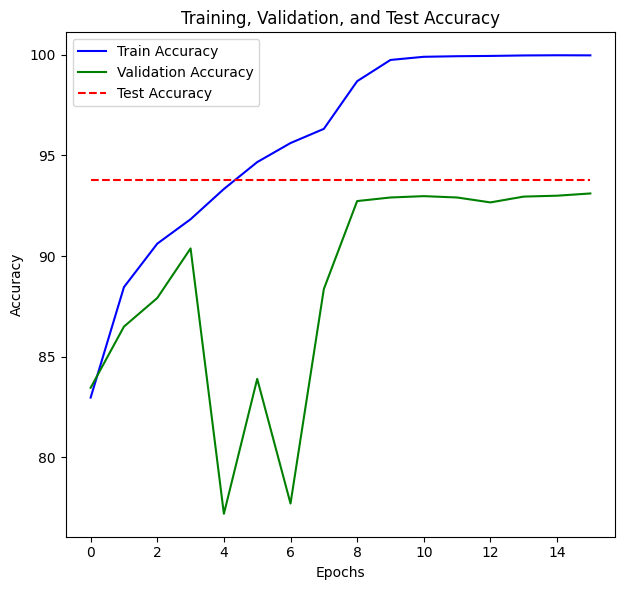

In [184]:
# Repeat the test accuracy and loss to match the number of epochs
test_acc_fin_resnet = [test_accuracy_fin_resnet * 100] * len(train_acc_fin_resnet)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_fin_resnet)), train_acc_fin_resnet, label="Train Accuracy", color='b')
plt.plot(range(len(train_acc_fin_resnet)), validation_acc_fin_resnet, label="Validation Accuracy", color='g')
plt.plot(range(len(train_acc_fin_resnet)), test_acc_fin_resnet, label="Test Accuracy", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

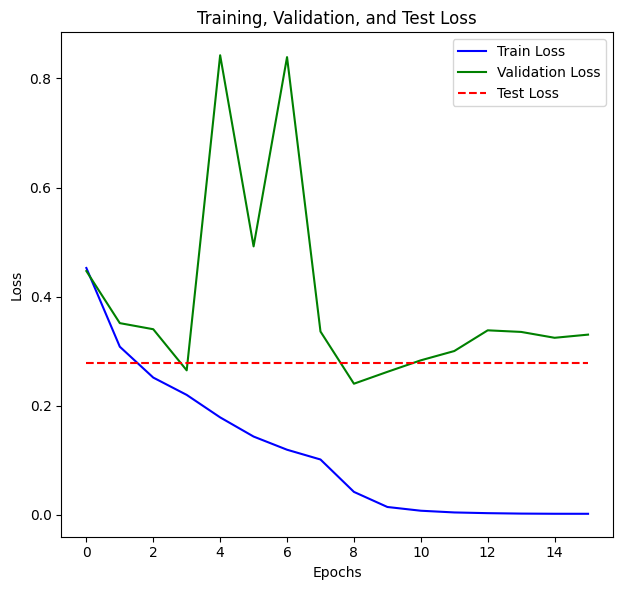

In [185]:
test_loss_fin_resnet = [test_loss_fin_resnet] * len(train_acc_fin_resnet)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_fin_resnet)), train_loss_fin_resnet, label="Train Loss", color='b')
plt.plot(range(len(train_acc_fin_resnet)), validation_loss_fin_resnet, label="Validation Loss", color='g')
plt.plot(range(len(train_acc_fin_resnet)), test_loss_fin_resnet, label="Test Loss", color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

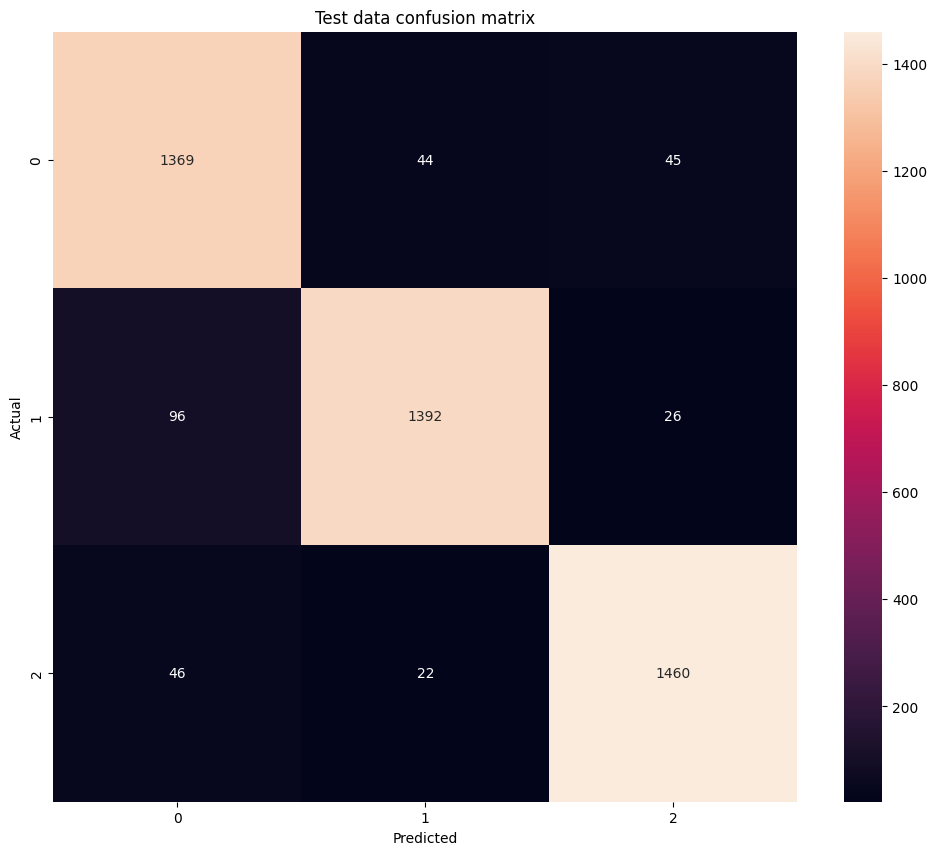

In [189]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix_test = confusion_matrix(actual_values_fin_resnet, predicted_val_fin_resnet)
plt.figure(figsize=(12, 10))
s = sns.heatmap(confusion_matrix_test, annot=True, fmt='d', xticklabels=np.arange(3), yticklabels=np.arange(3))
s.set(xlabel='Predicted', ylabel='Actual')
s.set_title('Test data confusion matrix')
plt.show()

Here also we can see that class 0 is misclassified the most like in VGG. Again this could be because of the images sharing similarities in features, shapes, texture, or other visual characteristics that Class 0 shares with other classes

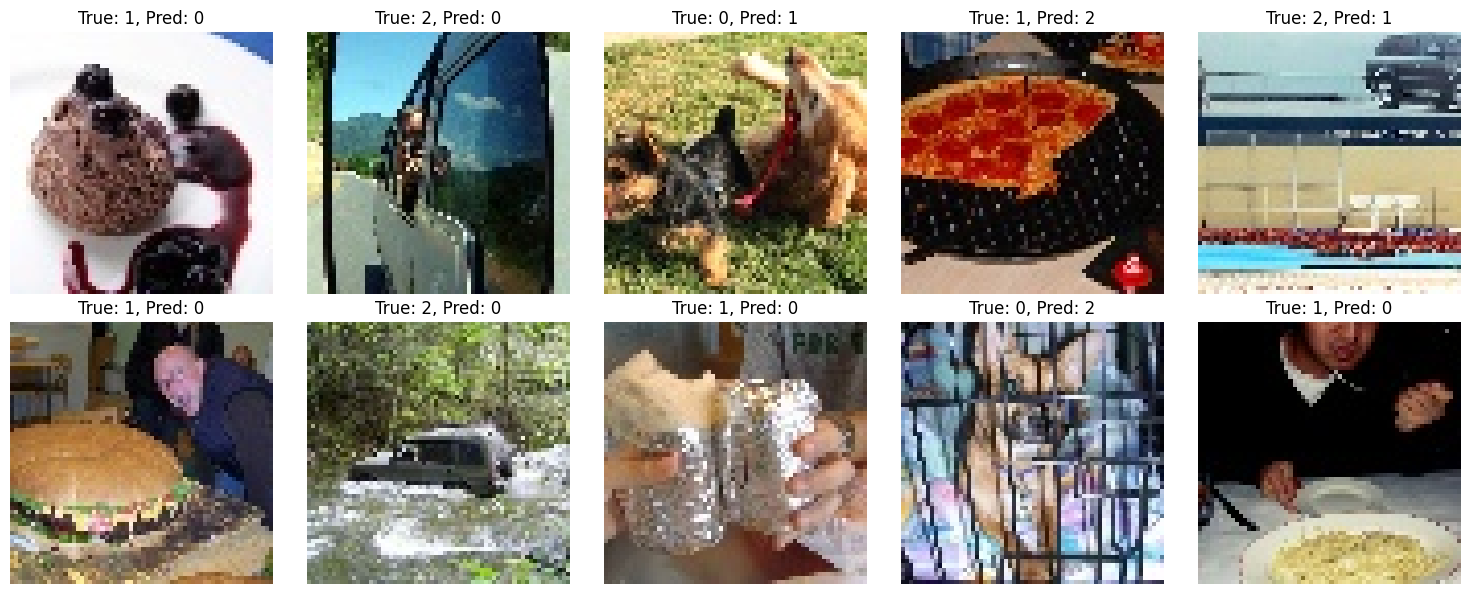

In [192]:
display_misclassified_images(test_loader_aug_res, model_fin_resnet, actual_values_fin_resnet, predicted_val_fin_resnet, num_to_display=10)

In [215]:
torch.save(model_fin_resnet.state_dict(), './a1_weights_res18_ha33_siyer8.pt')

# Evaluation and discussion of models

### Theortical discussion

#### 1. VGG: Discuss the idea of using small convolutional filters (3x3) and stacking multiple layers to increase depth.
   VGG standardizes 3×3 convolutional filters across the network, enabling deeper architectures while controlling the number of parameters. Using smaller filters instead of larger ones reduces the number of parameters while preserving the ability to capture local features effectively. By stacking multiple small filters, VGG enhances its capacity to learn hierarchical feature representations at different levels of abstraction. Also by stacking the same smaller layers, it helps form a more uniform structure, making it easier to understand, reproduce, and extend. Its consistency also enhances transfer learning, allowing seamless adaptation to various tasks and datasets.

#### 2. ResNet: Explain the problem of vanishing/exploding gradients in very deep networks and how residual connections address this issue. Explain the concept of "identity mapping."
The vanishing gradient problem occurs in deep networks when gradients shrink during backpropagation, leading to minimal weight updates in earlier layers. This slows down training and, in extreme cases, can halt it entirely. As gradients propagate backward, they become progressively smaller, preventing effective learning in initial layers and hindering model optimization.
ResNet addresses the problem of vanishing/exploding gradients that often occurs in very deep networks. ResNet introduces residual connections that allow the gradient to flow more easily through the network. Residual connections essentially skip certain layers and add their input directly to the output of deeper layers. This means that the gradient signal can flow more easily through the network, avoiding the vanishing gradient problem. The skip connection also helps to preserve the high-level features learned by the network. This process is also called as identity mapping, where the input to a block is added to its output, enabling the model to learn the residual (difference) between the input and output. 

### Impact of Regularization and Optimization Techniques on Model Performance

In this training, we applied **early stopping**, **image augmentation**, and **weight decay (L2 regularization)** to both the **VGG** and **ResNet** models, each contributing to improvements in the model’s ability to generalize and achieve optimal performance. Below is an analysis of how each technique influenced the performance of both models, based on the experimental results.

#### VGG Model:

1. **Early Stopping**:
   Initially, without early stopping, the model achieved an accuracy of **94.4%** and a test loss of **0.352**. However, after applying early stopping, accuracy slightly dropped to **93.6%**, but the test loss improved significantly, decreasing to **0.245**. This demonstrated that early stopping helped in preventing overfitting by halting training when the validation loss no longer improved, thus avoiding excessive training that could lead to memorizing the training data. The improvement in test loss indicates that early stopping contributed to better generalization by stopping the model before it could overfit.

2. **Image Augmentation**:
   Following the application of image augmentation, accuracy slightly decreased to **92.5%**, while test loss reduced to **0.331**. Image augmentation helped the model generalize better by increasing the effective size of the training dataset, exposing the model to a broader variety of input variations. Despite the slight drop in accuracy, the lower test loss indicates that the model became better at generalizing to new, unseen data, mitigating overfitting.

3. **Weight Decay (L2 Regularization)**:
   When weight decay was added in combination with early stopping and image augmentation, accuracy improved to **93.7%** and test loss decreased to **0.239**. Weight decay helped by penalizing excessively large weights, thereby simplifying the model and further improving its generalization ability. This combination of techniques resulted in the best overall performance for **VGG**, as evidenced by the improved accuracy and test loss.

#### ResNet Model:

For **ResNet**, we directly applied all three techniques (early stopping, image augmentation, and weight decay) together. This led to an accuracy of **93.8%** and a test loss of **0.2787**. Even though the accuracy is slightly higher than VGG's final result of **93.7%**, the test loss is slightly higher as well (**0.2787** vs **0.239** for VGG). This suggests that while ResNet benefited from the combined regularization and optimization techniques, it did not significantly outperform VGG in terms of test loss, but the accuracy improvement and faster training time indicate its superior efficiency.

#### Conclusion:

Based on the experimental results, it is clear that **early stopping** played a crucial role in preventing overfitting and ensuring both models generalized well to unseen data. For **VGG**, the combination of **early stopping**, **image augmentation**, and **weight decay** led to the best performance, with the highest accuracy and the lowest test loss. In contrast, **ResNet** achieved a slightly higher accuracy but with a higher test loss, though it benefited from a faster convergence time, thanks to its residual connections.

## Summary of models

For VGG

Early stopping! Training stopped after 11 epochs<br>  
**Training completed in:** 652.22 seconds<br>  
**Training accuracy:** 91.08441558441558<br>  
**Validation accuracy:** 90.26868686868687<br>  
**Test Accuracy:** 0.9373333333333334, **Precision:** 0.9374244145032883, **Recall:** 0.9373333333333334, **F1 Score:** 0.9373226646873922<br>  
**Test loss:** 0.23984664933375593<br>  

The model showed substantial improvement in accuracy over the epochs, with training accuracy reaching **97.66%** and validation accuracy peaking at **93.31%**. However, validation loss began to fluctuate after the 6th epoch, suggesting potential overfitting.<br>  
Early stopping was triggered after **4 consecutive epochs without improvement**, halting training at the **11th epoch**. The final recorded training accuracy was **91.08%**, with a validation accuracy of **90.27%**.<br>  
Despite slight fluctuations in validation accuracy, the model exhibited **strong generalization**. The test results reinforced its performance, achieving an accuracy of **93.73%**, precision of **93.74%**, recall of **93.73%**, and an **F1-score of 93.73%**. The final test loss was **0.2398**.<br>  
The application of **early stopping**, along with techniques like **weight decay (L2 regularization)** and **data augmentation**, helped reduce overfitting and ensured the model's robustness on unseen data.<br>  

**For Resnet**

Early stopping! Training stopped after 16 epochs<br>  
**Training completed in:** 434.04 seconds<br>  
**Training accuracy:** 95.74940476190476<br>  
**Validation accuracy:** 88.6625<br>  
**Test Accuracy:** 0.938, **Precision:** 0.9385744339430007, **Recall:** 0.938, **F1 Score:** 0.938079726000966<br>  
**Test loss:** 0.27873035803647106<br>  

The model exhibited consistent improvements in accuracy over the epochs, with training accuracy reaching **99.75%** and validation accuracy peaking at **93.11%**. However, validation loss started increasing after the 5th epoch, signaling potential overfitting.<br>  
Early stopping was triggered after **8 consecutive epochs without improvement**, halting training at the **16th epoch**. The final recorded training accuracy was **95.75%**, with a validation accuracy of **88.66%**.<br>  
Despite slight fluctuations in validation accuracy, the model maintained **strong generalization**. The test results further confirmed its performance, achieving an accuracy of **93.8%**, precision of **93.86%**, recall of **93.8%**, and an **F1-score of 93.81%**. The final test loss was **0.2787**.<br>  
The implementation of **early stopping**, alongside techniques like **weight decay (L2 regularization)** and **data augmentation**, helped mitigate overfitting while ensuring robust performance on unseen data.<br>  

## Result

From the above, we can see that **ResNet** performs slightly better than **VGG** in terms of overall accuracy (training, validation, and test), precision, recall, and F1 score. **VGG** has a slightly better test loss and validation accuracy, but the difference is minor. However, the significant advantage of **ResNet** over **VGG** is the time taken. **VGG** ran for **11 epochs** and still took over **600 seconds**, whereas **ResNet** completed **16 epochs** in just **434 seconds**. While the learning rates for the models are different, this time difference is noteworthy, making **ResNet** more efficient overall.

In very deep networks, gradients can become extremely small during backpropagation, making it difficult for the model to learn. Residual connections, or skip connections here might be potentially helping resnet allow the gradient to flow more easily through the network, thereby achieving better performance, albeit small, at a faster rate.  
Additionally, ResNet demonstrates strong generalization, as evidenced by the stable loss and accuracy curves after a certain number of epochs. This indicates that the model is not overfitting and is able to make accurate predictions on unseen data, a crucial aspect of real-world machine learning tasks. The presence of residual connections seems to contribute to this stable learning process, ensuring that ResNet remains robust as the training progresses.

# References


https://medium.com/data-scientists-diary/how-to-initialize-weights-in-pytorch-e912308459d4

https://medium.com/@sohaib.zafar522/choosing-the-right-pre-trained-model-a-guide-to-vggnet-resnet-googlenet-alexnet-and-inception-db7a8c918510

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

https://cs230.stanford.edu/section/4/

https://stackoverflow.com/questions/62537079/display-misclassified-images-in-pytorch

https://medium.com/@abhishekjainindore24/deep-learning-architecture-3-vgg-35f1c0d3c658#:~:text=VGG%20standardized%20the%20convolutional%20layers,massive%20increase%20in%20computational%20cost.

https://www.geeksforgeeks.org/vanishing-and-exploding-gradients-problems-in-deep-learning/

https://medium.com/@singhamit_/breaking-the-gradient-barrier-how-resnet-rescued-deep-learning-from-the-vanishing-gradient-problem-ffc7f33eae1a

https://ai.stackexchange.com/questions/15743/what-is-the-benefit-of-using-identity-mapping-layers-in-deep-neural-networks-lik